# OMA database Exploration and Analysis
# ===============================

In [1]:
# system imports
import os
import sys
import random
import math

# library imports
import duckdb as ddb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
from scipy import stats
from joblib import Parallel, delayed
from datasketch import MinHash, MinHashLSH

# local imports
import pairpro.user_blast as pp_ub


# stuff from the future
from Bio import Align
from Bio.Align import substitution_matrices
import re

from scipy.stats import mannwhitneyu

# Plot settings for seaborn
sns.set_context('talk')
sns.set_style('whitegrid')

## Connecting to OMA db (generated via script)

In [2]:
con = ddb.connect('../tmp/oma.db', read_only=True)

In [3]:
con

In [4]:
con.execute("DESCRIBE").df()

,table_name,column_names,column_types,temporary
0,pairs,"[protein1, protein2]","[VARCHAR, VARCHAR]",False
1,prok_pairs,"[protein1_oma_id, protein2_oma_id, protein1_un...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR]",False
2,proteins,"[id, description, sequence]","[VARCHAR, VARCHAR, VARCHAR]",False
3,uniprot,"[oma_id, uniprot_id, __null_dask_index__]","[VARCHAR, VARCHAR, BIGINT]",False


We have four tables as programmed!

In [5]:
con.execute("SHOW TABLES").df()

,name
0,pairs
1,prok_pairs
2,proteins
3,uniprot


In [6]:
con.execute("DESCRIBE pairs").df()

,column_name,column_type,null,key,default,extra
0,protein1,VARCHAR,YES,NaN,NaN,NaN
1,protein2,VARCHAR,YES,NaN,NaN,NaN


#### **Don't do the below**
---

In [ ]:
con.execute("SUMMARIZE pairs").df()

Breaks Kernel. Too big of a compute. (will attach a screenshot below.

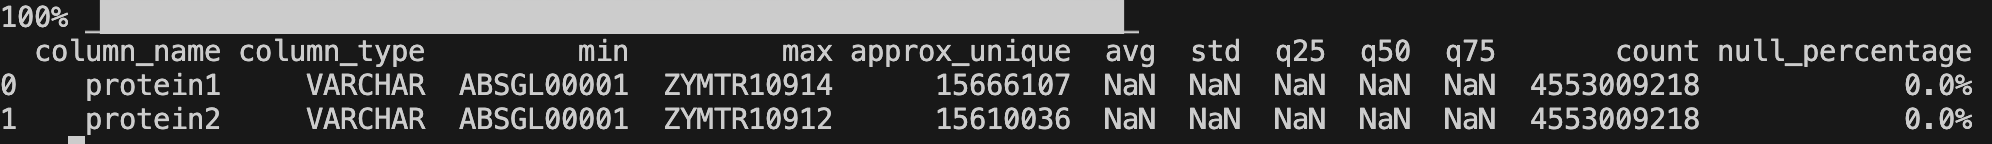

In [8]:
con.execute("SUMMARIZE prok_pairs").df()

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,protein1_oma_id,VARCHAR,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,%
1,protein2_oma_id,VARCHAR,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,%
2,protein1_uniprot_id,VARCHAR,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,%
3,protein2_uniprot_id,VARCHAR,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,%


In [ ]:
con.execute("SUMMARIZE proteins").df()

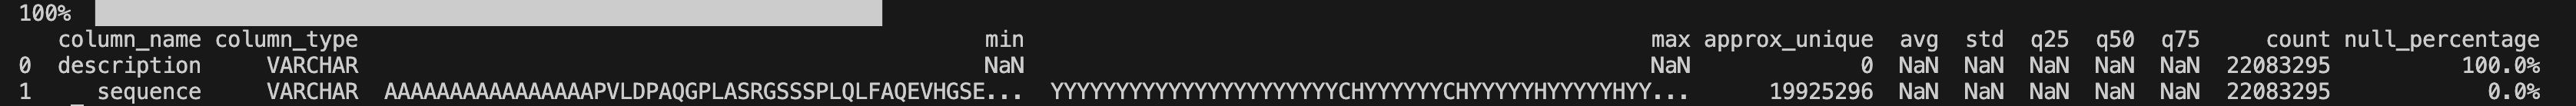

In [7]:
con.execute("SUMMARIZE uniprot").df()

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,oma_id,VARCHAR,ABSGL00001,ZYMTR09833,12421806,NaN,NaN,NaN,NaN,NaN,13669264,0.0%
1,uniprot_id,VARCHAR,104K_THEAN,ZZZ3_MOUSE,12347480,NaN,NaN,NaN,NaN,NaN,13669264,0.0%
2,__null_dask_index__,BIGINT,0,522081,508944,244401.77013992853,141465.4266976116,122078,243795,364710,13669264,0.0%


### Observations
So the *pairs* table, as expeceted, is the biggest one. It has 4.5 billion protein pairs, while the second biggest table is *proteins* with 22 million elements.
Update: some of the statistics above are out-dated now as I have updated the ingestion scripts.

## Analysis
We need statistical tests on the data as well as various viz.

Made a new script for sampling.
Need to somehow add a True Pair label.

Things to do:
- sampling negative protien pair space
- scipy false discovery to navigate that space
- use some alignment method to discriminate b/w proteins

In [7]:
# make sure the connection is closed
con.close()

---

### Aside: placeholder development

Forgot about making a true pair column.

### BLAST-ing once again

#### CSVs Reading

In [8]:
data_sample_100 = pd.read_csv("../data/OMA/samples/oma_sample_100.csv")
data_sample_10k = pd.read_csv("../data/OMA/samples/oma_sample_10000.csv")
data_sample_1m = pd.read_csv("../data/OMA/samples/oma_sample_1000000.csv")

In [9]:
data_sample_100

,protein1_uniprot_id,protein2_uniprot_id,protein1_sequence,protein2_sequence
0,NaN,NaN,MFQWLTSPEAWIALATLTALEIVLGIDNIIFISILVDRLPQDQRAK...,MSRSMIDTFHFHGPVFMDTLLTLAADPAVWAALLTLVVMEIVLGID...
1,A0A1W5DR29,NaN,MYAVFQSGGKQHRVSEGQTIRLEKLDIATGEAVEFDQILMIANGED...,MYAVFQSGGKQHRVAEGHTVRLEKLEVATGATVEFDQVLLIADGET...
2,NaN,NaN,MRILLPLIALFTLSGCSHMANDSWSGQDKAQHFIGSAMLSAAGNEY...,MRPLRPLLLLPVLLFSCGCTHMSNDSWTGKDKAQHFVASAAFAASG...
3,NaN,NaN,MGQKSNPNCVRLGFNKNWLSRWNAPDRKHAALWILEDEKIRKFLNK...,MGQKVHPVGFRLGIVRSWDSKWYEEKNYPKWLHEDINIRRFIKKEL...
4,NaN,NaN,MKLFPPIVTGTVVSLIGLTLLPVSIDWAAGGVGSANYGSLKNISIA...,MTTTTETSQTEAAAAPQRSELIYRLEDRPPLPQTLFAASQHLLAMF...
...,...,...,...,...
132,NaN,Q7BH47,MAKNRSELVAEVAGKAGTSQAAVNSVLDALFEVFETSVAAGEKITI...,MANKQDLIAEVAAKTGLTKKDSEKAVNAFGEVVTEFLAKGEKVQLI...
133,NaN,NaN,MRLASILARLGLQQQVGGGAAPCDTSKYILCVENVKKYFGGVRAVD...,MIEIDQLSFDYRTFSKEPGLKGALQDIFHRKYQLVPALKDLNLTIK...
134,A0A380ZZY6,NaN,MSNIVEIKVPDIGDFKEVEVIEVLVAAGDTIKAEQSLITVESDKAS...,MNKKIYTQVVVIGSGPAGYSAAFRCADLGLDTVLIERYDKLGGVCL...
135,NaN,P0A2E0,MAEHPTPPHRDLPDAGPLLNALMTCILVLDDDLVIRYANPAAQQLL...,MASGIQPDAGQILNSLINSVLVVDDALAIHYANPAAQQLLAQSSRK...


I am still not sure why we have such a large Null % for uniprot IDs. Did it not read the parquets? Are they not mapped? What are the implications?

**Note**: even though, we have a huge Null % of IDs. Checking the IDs that we do have, it seems right!

In [10]:
data_sample_10k

,protein1_uniprot_id,protein2_uniprot_id,protein1_sequence,protein2_sequence
0,A0A173WM95,E2QQ14,MKKGKLLIIDDNEDILFALNLLLEPYMEQIRVATQPERIDHFMRTF...,MSHKPAHLLLVDDDPGLLKLLGLRLTSEGYSVVTAESGAEGLRVLN...
1,A0A6A2SKM7,NaN,MDGTPEIDFDRFRPTRSAIQRRNIMDRFMWALIAVAFVIACIPLIS...,MSSNLKRRFINKVFVALCSLSTLLAVGMLALILGSLIINGAGGLHL...
2,A0A222J783,NaN,MQDLNDIALFAAVVKHNGFSAAARDLNVPKSKLSKHVARLEEQLGV...,MQSSIYGYLTYFHEIVNKGSIAAAARKLEIAPPAVSNALKLLERHL...
3,A0A222HJE5,NaN,MGQSLLPPSGGDDNIQPVDLKAALEERYLAYALSTIMHRALPDVRD...,MDDNTSDLFASPDAPESDALTLGNYAEQAYLSYAVSVVKSRALPDV...
4,A0A8B3NCH3,NaN,MPYRKAMNVATPIRQEKTIGHSVCPHDCPSACALEVDLTAEGRIGR...,MSKNEQMVGISRRTLVKSTAIGSLALAAGGFSLPFTLRSAAAAVQQ...
...,...,...,...,...
13866,NaN,NaN,MTDPAEAMARLDDRISRCRRCPRLVAWREQVAREKRAAYADEEYWG...,MPGFGDPAARIVLLGLAPGAHGANRTGRMFTGDGSGDFLYAALHRA...
13867,NaN,NaN,MARILIIEDDPSILDILRINLELAGYEVVKATDGVRGQALALQVLP...,MEGQRDGAGRCRRAPPAAGLRLPSAAERPTPVHPVGLTVTGAPRMR...
13868,NaN,A0A5C1T8T1,MPRRTPLPARRDPLPDRVSGTESSRATRTESSDPTPEQRILGLDPG...,MVILGIDPGSRITGFGVIKIQDNKVYYVASGCIRITETGTARRLKQ...
13869,NaN,A0A291KA92,MLMRVLIVEDELDLQNILVKRLNAEHYSVDACGNGEDALDYINMAT...,MKLLVAEDEPKTGTYLQQGLTEAGFNVDRVMTGTDALQHALSEAYD...


We return back to BLAST!

Let's work with the 1M sample. Let's process the data.

a) drop protein pairs that have the same uniprot IDs

b) drop the protein pairs that have the same protein sequence

c) drop null values

--

Summary = ~13.3% reduction!

In [11]:
id_id = data_sample_1m[data_sample_1m.protein1_uniprot_id == data_sample_1m.protein2_uniprot_id].index
data_sample_1m.drop(id_id, inplace=True)
data_sample_1m.reset_index(drop=True, inplace=True)

In [12]:
data_sample_1m

,protein1_uniprot_id,protein2_uniprot_id,protein1_sequence,protein2_sequence
0,NaN,A0A6L9JNT6,MKYVEVKNEYKRYKMGETTITANDDISFSIEKGELVIILGPSGAGK...,MISLKNVSKWYGQFQVLSDCSTEVKKGEVVVVCGPSGSGKSTLIKT...
1,NaN,A0A0E1NC03,MKYVEVKNEYKRYKMGETTITANDDISFSIEKGELVIILGPSGAGK...,MLSFNQVSAHYGKIQALHQVSLHIQQGEIVTLIGANGAGKTTLLGT...
2,NaN,NaN,MKYVEVKNEYKRYKMGETTITANDDISFSIEKGELVIILGPSGAGK...,MTSVDVLEVKSLTKSVSNGSGRLDILKGVDLQIKVGESLAIIGRSG...
3,A0A133CDF7,NaN,MHIQTKLIHGGISEDPTTGAVSVPIYQTSTYRQDGVGQPKQYEYSR...,MKQKSLLVKAGRNFKNYNGSMNPPVYHSSTILFPTYMDYLSAANGN...
4,NaN,NaN,MKTFKQKDLKDCGLAVLQSIFHHFYHKNLSINKLKDKAYYSHDGIN...,MRNFGYFEEDYTPKLSEKGLWRRILGYIHPFRIPFTGAILLSLFVT...
...,...,...,...,...
1399870,NaN,NaN,MSSSSREPAPQVSSLERSALFVATLTSFLGPFMISSVNVALPAIQA...,MNQSTTSYNRSVIVGIFLVGAFVAILNQTLLIPAIPHIMEEFNIDV...
1399871,A0A2S9UE17,A0A806X216,MSTSIQSNSAVLVHFTLKLEDGSTAESSRNSGKPALFRLGDGSLSQ...,MSTSVQSNSAVLVHFTLKLDDGSLAESTRNNGKPALFRLGDGSLSE...
1399872,A0A921M4W4,NaN,MNLRAKIAVVAASVFLAGCREMPGYFASDTTLARAGGKQLQLRDVE...,MIGKRSLSILAFSLLLLVFVACDRKSDQPGDRLLARVFNRELHLSD...
1399873,A0A921M4W4,NaN,MNLRAKIAVVAASVFLAGCREMPGYFASDTTLARAGGKQLQLRDVE...,MLLSLVSCEYFKKDSVPDAVVVLGKSYLDKDDIERLLPANYTTQDS...


In [13]:
seq_id = data_sample_1m[data_sample_1m.protein1_sequence == data_sample_1m.protein2_sequence].index
data_sample_1m.drop(seq_id, inplace=True)
data_sample_1m.reset_index(drop=True, inplace=True)

data_sample_1m.dropna(inplace=True)
data_sample_1m.reset_index(drop=True, inplace=True)
print(data_sample_1m.shape)

(133285, 4)


In [14]:
data_sample_1m

,protein1_uniprot_id,protein2_uniprot_id,protein1_sequence,protein2_sequence
0,A0A0Z0AGQ2,A0A0B1FWJ5,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLDNVLRIATRQSPLALWQAHYVKDKLMASHPGLVVELVPMVTRGD...
1,Q6GG35,A0A3M6C0D3,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MSCYYPSHSLSTDCSMSSREIRIATRKSALALWQAEYVKARLEQAH...
2,A0A122XQH6,A7FCP5,MKVNPNNIELIISAVKEDQYPETELSEVALSGRSNVGKSTFINSMI...,MTIRNYNYHMTHFVISAPDIRHLPRDEGIEVAFAGRSNAGKSSALN...
3,Q6GG26,A0A1C3HNW1,MPKMKTHRGAAKRVKRTASGQLKRSRAFTSHLFANKSTKQKRQLRK...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...
4,Q3ZUA8,A0A085QCH7,MKCPKCNSTQSKVVDSRHADELNAIRRRRECENCGTRFTTFEHIEV...,MPCYGGNMHCPFCSENDTKVIDSRLVADGHQVRRRRQCLACNERFT...
...,...,...,...,...
133280,A0A6L3RRM2,A0A3N4AWJ5,MSQIGETLIDVRGVSFTRGNRSIFDNISLTVPRGKVTAIMGPSGIG...,MKQLASNVMNLIEIRGMSFTRGERLIFADINMTVPRGKVTAIMGPS...
133281,A0A6L3RNT1,A0A3Z1Y3S0,MFKIITLLAGFLSVLSGVSYASDSVDLKVTATLEAAACTPTLSDGG...,MKKLLIATSVIIGLSTSAQAVESTAVLKLTGVLTNGACIPELSDGG...
133282,A0A2S9U7N9,Q153J1,MRSSAKQEELVKAFKALLKEEKFSSQGEIVQALQDQGFENINQSKV...,MRSSAKQEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKV...
133283,A0A2S9U7N0,A0A2T9HT12,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...


In [16]:
module_path=os.getcwd()

pp_up.__path__=module_path

In [17]:
module_path

'/mmfs1/gscratch/cheme/users/halanzi/git_repos/PairProphet/notebooks'

After processing the 1M sample (~13.3% reduction), checking the module_path is correct. We will finally run BLAST!

In [22]:
start = timer()
df_align, con = pp_up.make_blast_df(data_sample_1m[['protein1_sequence', 'protein2_sequence']], cpus=4, path='../data/OMA/samples/oma_sample_1m.db', module_path=module_path)
time_delta = timer() - start
print(f'Alignment time: {time_delta} seconds')

Found and skipped 54 row(s) containing
        invalid amino acid codes.
Alignment time: 41.86642542597838 seconds


Let's save this real quick

In [24]:
df_align[['protein1_alphafold_id', 'protein2_alphafold_id']] = data_sample_1m[['protein1_uniprot_id', 'protein2_uniprot_id']]
df_align.to_csv('../data/OMA/samples/oma_sample_1m_aligned.csv', index=False)

In [26]:
con #from blast function

In [28]:
pctid = con.execute("""SELECT local_gap_compressed_percent_id FROM protein_pairs""").df()

The max value for local gap compressed percent id = [0.99932705]


Text(0, 0.5, 'Count')

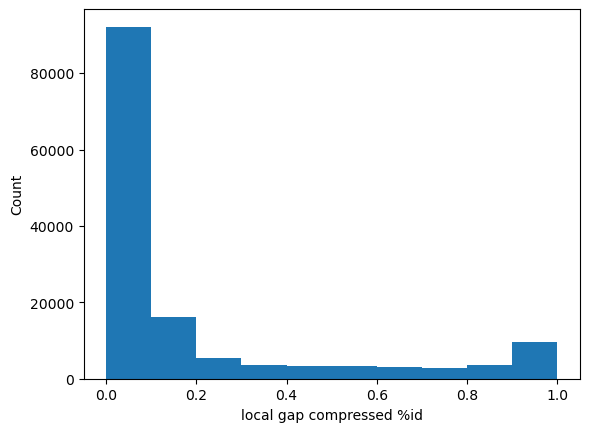

In [31]:
print(f"The max value for local gap compressed percent id = {max(pctid.values)}")

plt.hist(pctid)
plt.xlabel("local gap compressed %id")
plt.ylabel("Count")

---

### Bad Sampler

In [32]:
df_align

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id
0,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLDNVLRIATRQSPLALWQAHYVKDKLMASHPGLVVELVPMVTRGD...,56649,33244,0,0.061489,0.060703,0.060703,313,0.984026,313,1.000000,0.0,A0A0Z0AGQ2,A0A0B1FWJ5
1,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MSCYYPSHSLSTDCSMSSREIRIATRKSALALWQAEYVKARLEQAH...,56649,53558,1,0.045307,0.042683,0.042683,328,0.939024,328,1.000000,0.0,Q6GG35,A0A3M6C0D3
2,MKVNPNNIELIISAVKEDQYPETELSEVALSGRSNVGKSTFINSMI...,MTIRNYNYHMTHFVISAPDIRHLPRDEGIEVAFAGRSNAGKSSALN...,37556,67398,2,0.060914,0.055556,0.055556,216,0.907407,216,1.000000,0.0,A0A122XQH6,A7FCP5
3,MPKMKTHRGAAKRVKRTASGQLKRSRAFTSHLFANKSTKQKRQLRK...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...,50483,44669,3,0.111111,0.106061,0.106061,66,1.000000,66,0.939394,0.0,Q6GG26,A0A1C3HNW1
4,MKCPKCNSTQSKVVDSRHADELNAIRRRRECENCGTRFTTFEHIEV...,MPCYGGNMHCPFCSENDTKVIDSRLVADGHQVRRRRQCLACNERFT...,29198,43833,4,0.064103,0.064103,0.064103,156,1.000000,156,1.000000,0.0,Q3ZUA8,A0A085QCH7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143228,MSQIGETLIDVRGVSFTRGNRSIFDNISLTVPRGKVTAIMGPSGIG...,MKQLASNVMNLIEIRGMSFTRGERLIFADINMTVPRGKVTAIMGPS...,67228,30374,133228,0.066176,0.066176,0.066176,272,0.996324,272,1.000000,0.0,NaN,NaN
143229,MFKIITLLAGFLSVLSGVSYASDSVDLKVTATLEAAACTPTLSDGG...,MKKLLIATSVIIGLSTSAQAVESTAVLKLTGVLTNGACIPELSDGG...,19630,27787,133229,0.157895,0.157205,0.157205,229,0.991266,229,1.000000,0.0,NaN,NaN
143230,MRSSAKQEELVKAFKALLKEEKFSSQGEIVQALQDQGFENINQSKV...,MRSSAKQEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKV...,58126,52027,133230,0.955128,0.955128,0.955128,156,1.000000,156,1.000000,0.0,NaN,NaN
143231,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,71246,64816,133231,0.961145,0.961145,0.961145,489,1.000000,489,1.000000,0.0,NaN,NaN


Let's add ortho column, which indicates if the two pairs are orthologs or not. In this case, every one of them is an ortho

In [3]:
df_align["ortho"] = np.where((df_align["query"].notnull()) & (df_align["subject"].notnull()), True, False)

In [4]:
df_align

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id,ortho
0,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLDNVLRIATRQSPLALWQAHYVKDKLMASHPGLVVELVPMVTRGD...,56649,33244,0,0.061489,0.060703,0.060703,313,0.984026,313,1.000000,0.0,A0A0Z0AGQ2,A0A0B1FWJ5,True
1,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MSCYYPSHSLSTDCSMSSREIRIATRKSALALWQAEYVKARLEQAH...,56649,53558,1,0.045307,0.042683,0.042683,328,0.939024,328,1.000000,0.0,Q6GG35,A0A3M6C0D3,True
2,MKVNPNNIELIISAVKEDQYPETELSEVALSGRSNVGKSTFINSMI...,MTIRNYNYHMTHFVISAPDIRHLPRDEGIEVAFAGRSNAGKSSALN...,37556,67398,2,0.060914,0.055556,0.055556,216,0.907407,216,1.000000,0.0,A0A122XQH6,A7FCP5,True
3,MPKMKTHRGAAKRVKRTASGQLKRSRAFTSHLFANKSTKQKRQLRK...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...,50483,44669,3,0.111111,0.106061,0.106061,66,1.000000,66,0.939394,0.0,Q6GG26,A0A1C3HNW1,True
4,MKCPKCNSTQSKVVDSRHADELNAIRRRRECENCGTRFTTFEHIEV...,MPCYGGNMHCPFCSENDTKVIDSRLVADGHQVRRRRQCLACNERFT...,29198,43833,4,0.064103,0.064103,0.064103,156,1.000000,156,1.000000,0.0,Q3ZUA8,A0A085QCH7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143228,MSQIGETLIDVRGVSFTRGNRSIFDNISLTVPRGKVTAIMGPSGIG...,MKQLASNVMNLIEIRGMSFTRGERLIFADINMTVPRGKVTAIMGPS...,67228,30374,133228,0.066176,0.066176,0.066176,272,0.996324,272,1.000000,0.0,NaN,NaN,True
143229,MFKIITLLAGFLSVLSGVSYASDSVDLKVTATLEAAACTPTLSDGG...,MKKLLIATSVIIGLSTSAQAVESTAVLKLTGVLTNGACIPELSDGG...,19630,27787,133229,0.157895,0.157205,0.157205,229,0.991266,229,1.000000,0.0,NaN,NaN,True
143230,MRSSAKQEELVKAFKALLKEEKFSSQGEIVQALQDQGFENINQSKV...,MRSSAKQEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKV...,58126,52027,133230,0.955128,0.955128,0.955128,156,1.000000,156,1.000000,0.0,NaN,NaN,True
143231,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,71246,64816,133231,0.961145,0.961145,0.961145,489,1.000000,489,1.000000,0.0,NaN,NaN,True


Cool! Let's work on the bad sampler, and finally do some statistics!

Work-in-progress

#### archive

In [67]:
# Functions and stubs
# def bad_sampler(df: pd.DataFrame , num_samples: int, cols: list) -> pd.DataFrame:
#     """
#     TODO
#     Generate non-pair proteins.
#     """
#     bad_samples = pd.DataFrame(columns=cols)
#     print(f"Starting with {df.shape[0]} pairs")

#     while bad_samples.shape[0] < num_samples:
#         # check unique and non-self pairing
#         while True:
#             query_sample = df.sample(n=1)
#             subject_sample = df.sample(n=1)
#             # insurance check
#             if query_sample.index != subject_sample.index:
#                 break

#         # construct a potential bad pair
#         potential_bad_pair = pd.DataFrame({
#             cols[0]: query_sample[cols[0]].values,
#             cols[1]: subject_sample[cols[1]].values
#         })

#         # validate the bad pair
#         if is_valid_non_pair(potential_bad_pair.iloc[0][cols[0]], potential_bad_pair.iloc[0][cols[1]]):
#             bad_samples = pd.concat([bad_samples, potential_bad_pair], ignore_index=True)

#     return bad_samples


# def bad_sampler(df: pd.DataFrame , num_samples: int, cols: list) -> pd.DataFrame:
#     """
#     TODO
#     Generate non-pair proteins.
#     """
#     # initialize empty list
#     samples = []
#     while len(samples) < num_samples:
#         query_idx = df.sample(n=num_samples).index.item()
#         subject_idx = df.sample(n=num_samples).index.item()

#         # ensure no self-pairing
#         if query_idx != subject_idx:
#             # directly subset DataFrame to get query and subject values
#             query_value = df.loc[query_idx, cols[0]]
#             subject_value = df.loc[subject_idx, cols[1]]

#             # construct a potential bad pair
#             sample = {cols[0]: query_value, cols[1]: subject_value}

#             # validate the bad pair using is_valid_non_pair
#             if is_valid_non_pair(query_value, subject_value):
#                 samples.append(sample)
    
#     # create a dataframe from the samples
#     bad_samples_df = pd.DataFrame(samples)
#     return bad_samples_df

#### 01-29-24

In [3]:
df_align = pd.read_csv('../data/OMA/samples/oma_sample_1m_aligned.csv')

In [4]:
df_align["ortho"] = np.where((df_align["query"].notnull()) & (df_align["subject"].notnull()), True, False)

In [5]:
df_align

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id,ortho
0,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLDNVLRIATRQSPLALWQAHYVKDKLMASHPGLVVELVPMVTRGD...,56649,33244,0,0.061489,0.060703,0.060703,313,0.984026,313,1.000000,0.0,A0A0Z0AGQ2,A0A0B1FWJ5,True
1,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MSCYYPSHSLSTDCSMSSREIRIATRKSALALWQAEYVKARLEQAH...,56649,53558,1,0.045307,0.042683,0.042683,328,0.939024,328,1.000000,0.0,Q6GG35,A0A3M6C0D3,True
2,MKVNPNNIELIISAVKEDQYPETELSEVALSGRSNVGKSTFINSMI...,MTIRNYNYHMTHFVISAPDIRHLPRDEGIEVAFAGRSNAGKSSALN...,37556,67398,2,0.060914,0.055556,0.055556,216,0.907407,216,1.000000,0.0,A0A122XQH6,A7FCP5,True
3,MPKMKTHRGAAKRVKRTASGQLKRSRAFTSHLFANKSTKQKRQLRK...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...,50483,44669,3,0.111111,0.106061,0.106061,66,1.000000,66,0.939394,0.0,Q6GG26,A0A1C3HNW1,True
4,MKCPKCNSTQSKVVDSRHADELNAIRRRRECENCGTRFTTFEHIEV...,MPCYGGNMHCPFCSENDTKVIDSRLVADGHQVRRRRQCLACNERFT...,29198,43833,4,0.064103,0.064103,0.064103,156,1.000000,156,1.000000,0.0,Q3ZUA8,A0A085QCH7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143228,MSQIGETLIDVRGVSFTRGNRSIFDNISLTVPRGKVTAIMGPSGIG...,MKQLASNVMNLIEIRGMSFTRGERLIFADINMTVPRGKVTAIMGPS...,67228,30374,133228,0.066176,0.066176,0.066176,272,0.996324,272,1.000000,0.0,NaN,NaN,True
143229,MFKIITLLAGFLSVLSGVSYASDSVDLKVTATLEAAACTPTLSDGG...,MKKLLIATSVIIGLSTSAQAVESTAVLKLTGVLTNGACIPELSDGG...,19630,27787,133229,0.157895,0.157205,0.157205,229,0.991266,229,1.000000,0.0,NaN,NaN,True
143230,MRSSAKQEELVKAFKALLKEEKFSSQGEIVQALQDQGFENINQSKV...,MRSSAKQEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKV...,58126,52027,133230,0.955128,0.955128,0.955128,156,1.000000,156,1.000000,0.0,NaN,NaN,True
143231,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,71246,64816,133231,0.961145,0.961145,0.961145,489,1.000000,489,1.000000,0.0,NaN,NaN,True


In [2]:
def bad_sampler(df: pd.DataFrame, size: int, cols):
    bad_sample = pd.DataFrame(columns=cols)
    while bad_sample.shape[0] < size:
        # determine the number of samples needed in this iteration
        samples_needed = size - bad_sample.shape[0]
        # sample a fixed number of rows based on samples_needed
        sample_df = df.sample(n=samples_needed*2, replace=False).reset_index(drop=True)
        df_it = pd.DataFrame({
            'query': sample_df.iloc[:samples_needed][cols[0]].values,
            'subject': sample_df.iloc[samples_needed:][cols[1]].values
        })
        out, _ = pp_ub.make_blast_df(df_it, 4, path="blast_db.db")
        bad_sample = pd.concat([bad_sample, out], ignore_index=True, axis=0)
    return bad_sample

    

def is_valid_non_pair(protein1, protein2):
    """
    TODO
    Implement logic to check if the pair is a valid non-pair
    Example: Check sequence similarity, length difference, family/motif/domain annotation, drop real pairs, etc.
    Do I need to catalog used index pairs?
    """
    # Example check for sequence similarity (pseudo-code)
    # similarity_score = compute_similarity(protein1, protein2)
    # if similarity_score < threshold:
    #     return True
    # return False
    pass

##### Playground

In [30]:
df_align

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id,ortho
0,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLDNVLRIATRQSPLALWQAHYVKDKLMASHPGLVVELVPMVTRGD...,56649,33244,0,0.061489,0.060703,0.060703,313,0.984026,313,1.000000,0.0,A0A0Z0AGQ2,A0A0B1FWJ5,True
1,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MSCYYPSHSLSTDCSMSSREIRIATRKSALALWQAEYVKARLEQAH...,56649,53558,1,0.045307,0.042683,0.042683,328,0.939024,328,1.000000,0.0,Q6GG35,A0A3M6C0D3,True
2,MKVNPNNIELIISAVKEDQYPETELSEVALSGRSNVGKSTFINSMI...,MTIRNYNYHMTHFVISAPDIRHLPRDEGIEVAFAGRSNAGKSSALN...,37556,67398,2,0.060914,0.055556,0.055556,216,0.907407,216,1.000000,0.0,A0A122XQH6,A7FCP5,True
3,MPKMKTHRGAAKRVKRTASGQLKRSRAFTSHLFANKSTKQKRQLRK...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...,50483,44669,3,0.111111,0.106061,0.106061,66,1.000000,66,0.939394,0.0,Q6GG26,A0A1C3HNW1,True
4,MKCPKCNSTQSKVVDSRHADELNAIRRRRECENCGTRFTTFEHIEV...,MPCYGGNMHCPFCSENDTKVIDSRLVADGHQVRRRRQCLACNERFT...,29198,43833,4,0.064103,0.064103,0.064103,156,1.000000,156,1.000000,0.0,Q3ZUA8,A0A085QCH7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143228,MSQIGETLIDVRGVSFTRGNRSIFDNISLTVPRGKVTAIMGPSGIG...,MKQLASNVMNLIEIRGMSFTRGERLIFADINMTVPRGKVTAIMGPS...,67228,30374,133228,0.066176,0.066176,0.066176,272,0.996324,272,1.000000,0.0,NaN,NaN,True
143229,MFKIITLLAGFLSVLSGVSYASDSVDLKVTATLEAAACTPTLSDGG...,MKKLLIATSVIIGLSTSAQAVESTAVLKLTGVLTNGACIPELSDGG...,19630,27787,133229,0.157895,0.157205,0.157205,229,0.991266,229,1.000000,0.0,NaN,NaN,True
143230,MRSSAKQEELVKAFKALLKEEKFSSQGEIVQALQDQGFENINQSKV...,MRSSAKQEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKV...,58126,52027,133230,0.955128,0.955128,0.955128,156,1.000000,156,1.000000,0.0,NaN,NaN,True
143231,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,71246,64816,133231,0.961145,0.961145,0.961145,489,1.000000,489,1.000000,0.0,NaN,NaN,True


In [61]:
query_test_sample = df_align["query"].sample(frac=0.05)

In [62]:
subject_test_sample = df_align["subject"].sample(frac=0.05)

In [63]:
pd.DataFrame([query_test_sample.reset_index(drop=True), subject_test_sample.reset_index(drop=True)]).T

,query,subject
0,MSIQTRPRPDLRSTTAAPAARSRRRFTGGWVAYGLLVALALAYTFP...,MKKWLCAASLGLALAASASVQAADKIAIVNVSSIFQQLPAREAVAK...
1,MSKEKFERTKPHVNVGTIGHVDHGKTTLTAAITTVLAKTYGGSARA...,MRIDEIVEKYVDRKTQRRFLILTSIAWMFDAAGVMLLSFVLPYVIK...
2,MNKTELIKNVAQSADISQKDASAAVQSVFDTIATALQSGDKVQLIG...,MLTPIIRKFQYGQHTVTIETGMMARQATAAVMVSMDDTAVFVTVVG...
3,MSQLPGLSRETRESIAMYHLRVPQTEEELERYYQFRWEMLRKPLHQ...,MVQGTLYIVSAPSGAGKSSLIQALLKTQPLYDTQVSISHTTRAKRP...
4,MRHKHGYRKLGRTSSHRKALLKNLAIALIEHNKIETGIYKAKELRS...,MPRVRVIGSDGEMVGVLSRDEALAKAEEEGLDLVEIQPQADPPVCK...
...,...,...
7157,MTIKNVICDIDGVLMHDNVAVPGAAEFLHGIMDKGLPLVLLTNYPS...,MSKQQIGVVGMAVMGRNLALNIESRGYTVSVFNRSREKTEEVIAEN...
7158,MYDTIVIGAGPAGMTAALYAARANLKVATLEQGAPGGQMNNTSDIE...,MTAATPGHSGRFDCVIFDCDGVLVDSEPIVNRVLNQMLNELGIEIS...
7159,MLEIKNLTGGYVHVPVLKDVSFTVESGQLVGLIGLNGAGKSTTINE...,MMNKDEAGGNWKQFKGKMKEQWGKLTDDDMTVIEGKRDQLVGKIQE...
7160,MEKTLSIIKPDAVKKGVIGKILDRFESNGLRIAAMKKVQLSKEQAE...,MNEIREAAVQTPEQATAVIRAEALAKTYAEGKMRTPVFDGLDLSVA...


In [7]:
query_test_sample.shape

NameError: name 'query_test_sample' is not defined

In [18]:
test_df = df_align[:100]

##### Testing

In [14]:
test_cols = ["query", "subject"]

In [36]:
test_cols

['query', 'subject']

In [15]:
start = timer()
blah1 = bad_sampler(test_df, 30, cols=test_cols)
print(f"time to compute = {timer()-start} seconds")

time to compute = 0.09671520511619747 seconds


Take forever....

In [ ]:
blah1

In [55]:
blah1["query"][0]

['MSFSFDSASVQGAVIKVIGVGGGGGNAINRMIEEGLSGVEFIAANTDIQALSSSKAETVIQLGPKLTRGLGAGGQPEVGRKAAEESEETLTEALTGADMVFITAGMGGGSGTGAAPVIARIAKSLGALTVAVVTRPFGFEGNKRSSFAIEGIQELREQVDTLLIISNNNLLEIVDKKTPLLEALSEADNVLRQGVQGITDLITNPGLINLDFADVKTVMANKGNALMGIGIGSGEERIVEAARKAIYSPLLETTIDGAEDVIVNVTGGLDMTLTEAEEASEIVGQAAGNGVNIWLGTSIDDTLKDEIRVTVVATGVRQERAEKVSGMKAQPRKVTTAPSQSSVPNQQVAQEQQRLGSQASFERQPNFDYNETHSMSQPGVRPTMAAPQQEQSAFGNWDLRRDNISRPKTGELDSQLTMSTFSSDVEDDDELETPPFFKNR',
 'MRLNVNEISDIIRNRIKQLDIGCETRNEGTITSVADGVIYIHGLSNVMQGEMIALPYNKFAIALNLESSATGAIVMGSYENISEGMVVKCTGDILRVPVGPELLGRVVNALGVPIDNKGLINCSNYYPIESDAPGVIDRQSINEPIQTGYKSIDSMVPIGRGQRELIIGDRQTGKSALAIDTIINQSCSGVKCIYVAIGQKATTVVNVVKKLEEYHALDNTIVILASASESAILQYLAPYSGCAMGEYFRNNGQDALIVYDDLSKQAVAYRQLSLLLRRPPGREAYPGDIFYLHSRLLERSAKVRSEYIERCTQGKITGKTGSLTALPIIETQAGDVSAFIPTNVISITDGQIFLESQLFNAGVRPAINPGISVSRVGGSAQTKIMKVLSGGIRTALAQYRELAAFSQFSSELDNVTRKQLQHGQKVTELLKQKQYSCMSVACQAIILFAVSYGYLEDIELSKIGDFEAKLISYLTYHELELVKHINIYGSYDSNIENKLKNILEMFKLNKFS']

In [56]:
type(blah1["query"][0])

list

In [5]:
test_df

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id,ortho
0,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLDNVLRIATRQSPLALWQAHYVKDKLMASHPGLVVELVPMVTRGD...,56649,33244,0,0.061489,0.060703,0.060703,313,0.984026,313,1.000000,0.0,A0A0Z0AGQ2,A0A0B1FWJ5,True
1,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MSCYYPSHSLSTDCSMSSREIRIATRKSALALWQAEYVKARLEQAH...,56649,53558,1,0.045307,0.042683,0.042683,328,0.939024,328,1.000000,0.0,Q6GG35,A0A3M6C0D3,True
2,MKVNPNNIELIISAVKEDQYPETELSEVALSGRSNVGKSTFINSMI...,MTIRNYNYHMTHFVISAPDIRHLPRDEGIEVAFAGRSNAGKSSALN...,37556,67398,2,0.060914,0.055556,0.055556,216,0.907407,216,1.000000,0.0,A0A122XQH6,A7FCP5,True
3,MPKMKTHRGAAKRVKRTASGQLKRSRAFTSHLFANKSTKQKRQLRK...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...,50483,44669,3,0.111111,0.106061,0.106061,66,1.000000,66,0.939394,0.0,Q6GG26,A0A1C3HNW1,True
4,MKCPKCNSTQSKVVDSRHADELNAIRRRRECENCGTRFTTFEHIEV...,MPCYGGNMHCPFCSENDTKVIDSRLVADGHQVRRRRQCLACNERFT...,29198,43833,4,0.064103,0.064103,0.064103,156,1.000000,156,1.000000,0.0,Q3ZUA8,A0A085QCH7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,MSGKTVTRADLAESVFRKVGLSRTESAELVETVIDEICNAIVRGES...,MALTKAEMSEHLFEKLGLSKRDAKDLVELFFEEVRRALENGEQVKL...,62675,5522,52176,0.050505,0.044643,0.044643,112,1.000000,112,0.875000,0.0,A0A0M0QX41,Q8EER2,True
96,MDISRAEQRILHHLAQGGRIEITREGKAIAEIRCFTRDGWVYPGVD...,MNLSRQEQRTLHVLAKGGRITHIRDASGRVTAVECYSREGLLLADC...,13041,41251,81,0.294118,0.294118,0.294118,85,0.988235,85,1.000000,0.0,A0A0F7J7N7,SYS_YERPE,True
97,MRRDALDGRKKCRRRVAGNAGFQPLKAHDKPPSRTIRKEGRGAMND...,MSYAFPGTFPGRRMRRVRCHDFSRRLVAENHLTVNDLIYPVFVMEG...,57778,64552,82,0.085044,0.076316,0.076316,380,1.000000,380,0.894737,0.0,A0A2J0RDD5,P43751,True
98,MNGQTPTDGGILYDATETDDEDDLVEVTEAERPAPAIGWAESLPEA...,MILKNNIAYAENEQEKLSFLSHITWDDAHQRNDKNQFKGAKLIQEF...,44802,22221,83,0.063444,0.062315,0.062315,674,1.000000,674,0.980712,0.0,A0A3Y7V9J9,Q8ZGC6,True


In [8]:
test_out, con = pp_ub.make_blast_df(test_df, 3, path="blast_db.db")

In [16]:
con.close()

The problem was the path....

In [18]:
blah1

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score
0,MNGQTPTDGGILYDATETDDEDDLVEVTEAERPAPAIGWAESLPEA...,MTNHKIKYYVVTTLFVAIVMLQFFVPWLGLLPLGAFVIGASATIIP...,17.0,26.0,0.0,0.073171,0.022255,0.022255,674.0,1.000000,674.0,0.302671,0.0
1,MAETKVILTKTVSNLGHSGDVVDVKSGYARNYLFPQGLAFAWTKGA...,MKIRTLSGSVLEPPSAVRATPGTSMLKLEPGGSTIPKIPFIRPSFP...,2.0,10.0,1.0,0.127517,0.046117,0.046117,412.0,0.359223,412.0,1.000000,0.0
2,MMTQAASGIDLFIPEVYDIVWSLIILVIVAVFFYKFFMPKFNAIFD...,MHCPFCFAVDTKVIDSRLVGEGSSVRRRRQCLVCNERFTTFEVAEL...,15.0,7.0,2.0,0.046667,0.040462,0.040462,173.0,1.000000,173.0,0.861272,0.0
3,MKITVIGAGSWGTALALHFSQHGNRVSLWTRNADQVRQMQEARENK...,MRIDILSIFPEMFGPLNQSIVGKAQDKGILELHTHDFRENATNKQR...,14.0,21.0,3.0,0.076613,0.057751,0.057751,329.0,1.000000,329.0,0.750760,0.0
4,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLQPTRLKYRKQQKGRNTGIATRGNKVSFGEFGLKAVGRGRLTARQ...,22.0,13.0,4.0,0.043165,0.019481,0.019481,308.0,1.000000,308.0,0.448052,0.0
5,MAQERRGSREDRQNREERDSEFVDKLVAINRVAKVVKGGRRFGFAA...,MNQRNASMTVIGAGSYGTALAITLARNGHEVVLWGHDPEHIATLER...,6.0,14.0,5.0,0.078947,0.044248,0.044248,339.0,0.557522,339.0,1.000000,0.0
6,MALQITDANFEELVNSGKPMVLDFWAEWCGPCRMVSPIIDELATEY...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...,5.0,16.0,6.0,0.047619,0.028571,0.028571,105.0,1.000000,105.0,0.590476,0.0
7,MSGKTVTRADLAESVFRKVGLSRTESAELVETVIDEICNAIVRGES...,MATNAKPVYKRILLKLSGEALQGTEGFGIDASILDRMAQEIKELVE...,24.0,3.0,7.0,0.053097,0.024896,0.024896,241.0,0.464730,241.0,1.000000,0.0
8,MGSQLALKSRIRSTESLAKIFNAQEMIASSHIAKARDVALNAKPYT...,MNQRNASMTVIGAGSYGTALAITLARNGHEVVLWGHDPEHIATLER...,9.0,14.0,8.0,0.048701,0.044248,0.044248,339.0,0.905605,339.0,1.000000,0.0
9,MIDTKQLIKAGEEKMTFAIEYLDEQLSHIRAGKANPKILDCVKVMY...,MASVQLRNVTKAWGDVVVSKDINLDIHDGEFVVFVGPSGCGKSTLL...,10.0,2.0,9.0,0.085106,0.043360,0.043360,369.0,0.506775,369.0,1.000000,0.0


- We get everything, but 'bit_score,' which is a zero. Potentially something to investigate it.
- Think through other alignment methods.

#### 01-31-24

Goals:
* BLAST vs Jaccard speed tests on similar CPU core
* Work on is_valid_non_pair function
    * Threseholds, etc.
* Stat intuition 

#### 02-01-24

In [13]:
from datasketch import MinHash, MinHashLSH
import nltk

In [17]:
def compute_protein_kgram(seq, k=3):
    """Find all k-grams in a amino acid sequence.
    
    No spaces are accepted.
    
    Parameters
    ----------
    seq: str
        Protein sequence
    k : int
        Size of grams
        
    Returns
    -------
    list of tuple of str
    """
    if " " in seq:
        raise ValueError(f"Ensure no spaces are in input: {seq}")
    else:
        return nltk.ngrams(seq, k)
        
def compute_min_hash(seq, k=3, num_perm=500):
    """Compute the MinHash of a protein sequence based on kgrams
    
    Parameters
    ----------
    seq: str of protein sequence
    k: size of k grams
    n: number of permutations for minhash
    """
    minhash = MinHash(num_perm=num_perm)
    grams = compute_protein_kgram(seq, k=k)
    for g in grams:
        minhash.update("".join(g).encode('utf-8')) # make explicit the string method encoding? 
    return minhash

def quick_jaccard(s1, s2):
    """
    {HA updated} Calculates the Jaccard similarity between sequence 1 (set) and sequence 2 (set) pairs based on minhashing

    Jaccard similarity is defined as the size of the intersection divided by the size of the union of two sets.

    Parameters
    ----------
    s1: protein sequence
    s2: protein sequence
    """
    # intersection = len(s1.intersection(s2))
    # union = len(s1.union(s2))
    # jaccard_similarity = intersection / union if union > 0 else 0
    # return jaccard_similarity
    return s1.jaccard(s2)

def parallel_jaccard(row):
    """
    Calculate the Jaccard similarity between two protein sequences in a DataFrame row using MinHash.
    """
    return quick_jaccard(compute_min_hash(row['subject']), compute_min_hash(row['query']))

def apply_parallel_jaccard(df, cpus):
    """
    Apply the parallel_jaccard function to each row of the DataFrame in parallel.
    """
    # Using delayed to wrap the parallel_jaccard function; n_jobs=-1 uses all available CPUs
    results = Parallel(n_jobs=cpus)(delayed(parallel_jaccard)(row) for index, row in df.iterrows())

    # Add the results as a new column to the DataFrame
    df['jaccard_similarity'] = results
    return df

In [19]:
start = timer()
result_df = apply_parallel_jaccard(test_df, 3)
print(f"time to compute = {timer()-start} seconds")

time to compute = 11.963620631955564 seconds


/tmp/ipykernel_38458/2604836295.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['jaccard_similarity'] = results


Comments

- BLAST (0.09671520511619747 seconds)
- Minhash (11.963620631955564 seconds)

**Viz**

In [21]:
copy_df = df_align

In [24]:
start = timer()
result_df = apply_parallel_jaccard(copy_df, 3)
print(f"time to compute = {timer()-start} seconds")

time to compute = 700.9298193799332 seconds


In [23]:
pctid = df_align["scaled_local_symmetric_percent_id"]

The max value for local gap compressed percent id = 0.9993270524899058


Text(0, 0.5, 'Count')

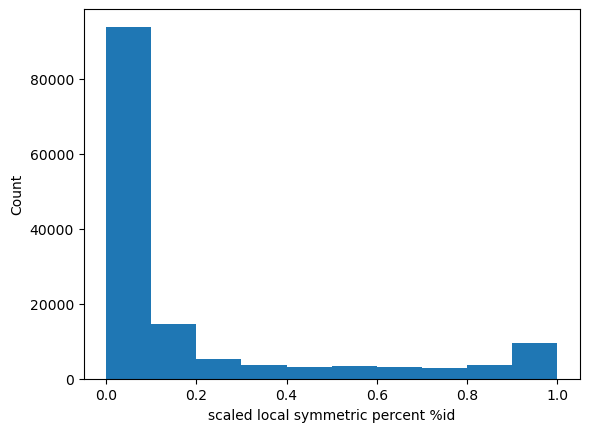

In [25]:
print(f"The max value for local gap compressed percent id = {max(pctid.values)}")

plt.hist(pctid)
plt.xlabel("scaled local symmetric percent %id")
plt.ylabel("Count")

The max value for local gap compressed percent id = 1.0


Text(0, 0.5, 'Count')

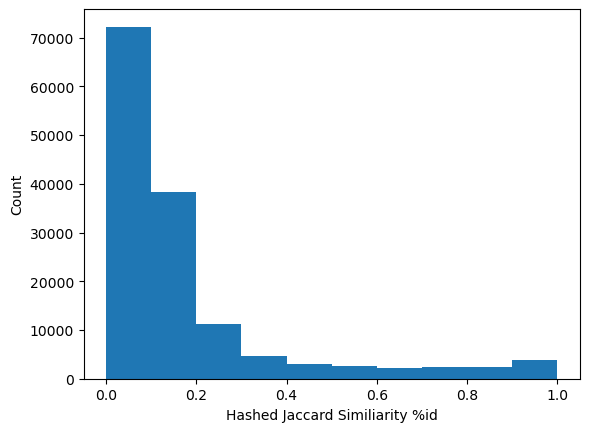

In [40]:
print(f"The max value for local gap compressed percent id = {max(copy_df['jaccard_similarity'].values)}")
plt.hist(copy_df['jaccard_similarity'])
plt.xlabel("Hashed Jaccard Similiarity %id")
plt.ylabel("Count")

Kinda looks similiar except at distinguishing negatives

### non-pairs

Function as they exists now:

In [6]:
def bad_sampler(df: pd.DataFrame, size: int, cols):
    """
    TODO
    """
    bad_sample = pd.DataFrame(columns=cols)
    while bad_sample.shape[0] < size:
        # determine the number of samples needed in this iteration
        samples_needed = size - bad_sample.shape[0]
        # sample a fixed number of rows based on samples_needed
        sample_df = df.sample(n=samples_needed*2, replace=False).reset_index(drop=True)
        df_it = pd.DataFrame({
            'query': sample_df.iloc[:samples_needed][cols[0]].values,
            'subject': sample_df.iloc[samples_needed:][cols[1]].values
        })
        out, _ = pp_ub.make_blast_df(df_it, 4, path="blast_db.db")
        bad_sample = pd.concat([bad_sample, out], ignore_index=True, axis=0)
    return bad_sample

    

def is_valid_non_pair(protein1, protein2):
    """
    TODO
    Implement logic to check if the pair is a valid non-pair
    Example: Check sequence similarity, length difference, family/motif/domain annotation, drop real pairs, etc.
    Do I need to catalog used index pairs?
    """
    # Example check for sequence similarity (pseudo-code)
    # similarity_score = compute_similarity(protein1, protein2)
    # if similarity_score < threshold:
    #     return True
    # return False
    pass

In [7]:
df_align

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id,ortho
0,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLDNVLRIATRQSPLALWQAHYVKDKLMASHPGLVVELVPMVTRGD...,56649,33244,0,0.061489,0.060703,0.060703,313,0.984026,313,1.000000,0.0,A0A0Z0AGQ2,A0A0B1FWJ5,True
1,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MSCYYPSHSLSTDCSMSSREIRIATRKSALALWQAEYVKARLEQAH...,56649,53558,1,0.045307,0.042683,0.042683,328,0.939024,328,1.000000,0.0,Q6GG35,A0A3M6C0D3,True
2,MKVNPNNIELIISAVKEDQYPETELSEVALSGRSNVGKSTFINSMI...,MTIRNYNYHMTHFVISAPDIRHLPRDEGIEVAFAGRSNAGKSSALN...,37556,67398,2,0.060914,0.055556,0.055556,216,0.907407,216,1.000000,0.0,A0A122XQH6,A7FCP5,True
3,MPKMKTHRGAAKRVKRTASGQLKRSRAFTSHLFANKSTKQKRQLRK...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...,50483,44669,3,0.111111,0.106061,0.106061,66,1.000000,66,0.939394,0.0,Q6GG26,A0A1C3HNW1,True
4,MKCPKCNSTQSKVVDSRHADELNAIRRRRECENCGTRFTTFEHIEV...,MPCYGGNMHCPFCSENDTKVIDSRLVADGHQVRRRRQCLACNERFT...,29198,43833,4,0.064103,0.064103,0.064103,156,1.000000,156,1.000000,0.0,Q3ZUA8,A0A085QCH7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143228,MSQIGETLIDVRGVSFTRGNRSIFDNISLTVPRGKVTAIMGPSGIG...,MKQLASNVMNLIEIRGMSFTRGERLIFADINMTVPRGKVTAIMGPS...,67228,30374,133228,0.066176,0.066176,0.066176,272,0.996324,272,1.000000,0.0,NaN,NaN,True
143229,MFKIITLLAGFLSVLSGVSYASDSVDLKVTATLEAAACTPTLSDGG...,MKKLLIATSVIIGLSTSAQAVESTAVLKLTGVLTNGACIPELSDGG...,19630,27787,133229,0.157895,0.157205,0.157205,229,0.991266,229,1.000000,0.0,NaN,NaN,True
143230,MRSSAKQEELVKAFKALLKEEKFSSQGEIVQALQDQGFENINQSKV...,MRSSAKQEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKV...,58126,52027,133230,0.955128,0.955128,0.955128,156,1.000000,156,1.000000,0.0,NaN,NaN,True
143231,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,MTAELLVNVTPSETRVAYIDGGILQEIHIEREARRGIVGNIYKGRV...,71246,64816,133231,0.961145,0.961145,0.961145,489,1.000000,489,1.000000,0.0,NaN,NaN,True


**Bad sampling of ~100k/2 seqs**

In [9]:
copy_df = df_align

In [12]:
test_cols = ["query", "subject"]
start = timer()
blah1 = bad_sampler(copy_df, 71616, cols=test_cols)
print(f"time to compute = {timer()-start} seconds")

time to compute = 27.33684036694467 seconds


In [14]:
blah1

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score
0,MKTIELHITLQPQVLDTQGQTLTRAVHDLGYAQVNDIRVGKVLYMT...,MTSRLQVIQGDITQLSVDAIVNAANASLMGGGGVDGAIHRAAGPAL...,21662.0,42076.0,0.0,0.056818,0.027933,0.027933,179.0,0.486034,179.0,1.000000,0.0
1,MVEYDYEELLERAYEQLPEEVLEDRRFEMPKPKVSVEGKTTVIRNF...,MRLILISGLSGSGKSVALRALEDSGFYCVDNLPATMLPEAMAMYDD...,47521.0,30332.0,1.0,0.071942,0.035714,0.035714,280.0,0.492857,280.0,1.000000,0.0
2,MEGVNEKTKRILVVDDEPNIVELLNVSLKFQGFDVATANSGVEALE...,MQQSTPYLSFRGIGKTFPGVKALTDISFDCYAGQVHALMGENGAGK...,9369.0,28665.0,2.0,0.037815,0.017857,0.017857,504.0,0.470238,504.0,1.000000,0.0
3,MSIIKEFREFAMRGNVVDLAVGVIIGAAFGKIVSSLVADIIMPPLG...,MPRKGPAPKRPVMVDPVYGSPLVSQLVSKILLDGKKTVAQNIVYTA...,37279.0,27009.0,3.0,0.043796,0.038462,0.038462,156.0,0.871795,156.0,1.000000,0.0
4,MAAFDRQSFSLTGKVALITGGARGLGKYYSLALSLYGADIFIVSQS...,MTQDELKKAVGWAALQYVQPGTIVGVGTGSTAAHFIDALGTMKGQI...,44.0,41506.0,4.0,0.090909,0.077821,0.077821,257.0,1.000000,257.0,0.852140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71619,MLDIQLLRSNTAAVAERLAARGYKFDAARFNALEEQRKAVQVKTEE...,MAYSTQRSEQLFTAAQQSIPGGVNSPVRAFNGVGGTPRFIAKADGA...,22562.0,6081.0,71611.0,0.074246,0.074246,0.074246,431.0,1.000000,431.0,1.000000,0.0
71620,MPRVKRGVTARARHQKIFALAKGYRGRRKNVYRVAKQAVMKAGQYA...,MDTAQKQRWAITLSYDGSRFYGWQKQADGVPTVQAALETALAQIAG...,30450.0,7377.0,71612.0,0.050000,0.022642,0.022642,265.0,0.449057,265.0,1.000000,0.0
71621,MKDIIDTFRPDLFAGKDILVTGGSSGIGLAIAQGFARLGGSVIALG...,MFQQQKDWETRENAFAAFTMGPLTDFWRQRDEAEFTGVDDIPVRFV...,17324.0,10006.0,71613.0,0.051383,0.038235,0.038235,340.0,0.741176,340.0,1.000000,0.0
71622,MSARCQITGRTVGFGKAVSHSHRRTRRRWPPNIQLKAYYLPSEDRR...,MADLSSLKDLGTVSEAAAPAHVRKVDSLGRSYATGKRKNAVARVWV...,35050.0,439.0,71614.0,0.010526,0.006452,0.006452,155.0,0.606452,155.0,1.000000,0.0


I have two dataframe. All good and all bad lol.

In [16]:
test_valid_df = pd.concat([copy_df, blah1], ignore_index=True, axis=0)

In [17]:
test_valid_df

/gscratch/cheme/users/halanzi/mambaforge/envs/pairpro/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/gscratch/cheme/users/halanzi/mambaforge/envs/pairpro/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id,ortho
0,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MLDNVLRIATRQSPLALWQAHYVKDKLMASHPGLVVELVPMVTRGD...,56649.0,33244.0,0.0,0.061489,0.060703,0.060703,313.0,0.984026,313.0,1.000000,0.0,A0A0Z0AGQ2,A0A0B1FWJ5,True
1,MRKLVVGSRRSKLALTQSQQFIDKLKAVEPNLEIEIKEIVTKGDRI...,MSCYYPSHSLSTDCSMSSREIRIATRKSALALWQAEYVKARLEQAH...,56649.0,53558.0,1.0,0.045307,0.042683,0.042683,328.0,0.939024,328.0,1.000000,0.0,Q6GG35,A0A3M6C0D3,True
2,MKVNPNNIELIISAVKEDQYPETELSEVALSGRSNVGKSTFINSMI...,MTIRNYNYHMTHFVISAPDIRHLPRDEGIEVAFAGRSNAGKSSALN...,37556.0,67398.0,2.0,0.060914,0.055556,0.055556,216.0,0.907407,216.0,1.000000,0.0,A0A122XQH6,A7FCP5,True
3,MPKMKTHRGAAKRVKRTASGQLKRSRAFTSHLFANKSTKQKRQLRK...,MPKMKTHRGAAKRFKKTASGYKRSHSHARHILTKKSTKRKRGLRGT...,50483.0,44669.0,3.0,0.111111,0.106061,0.106061,66.0,1.000000,66.0,0.939394,0.0,Q6GG26,A0A1C3HNW1,True
4,MKCPKCNSTQSKVVDSRHADELNAIRRRRECENCGTRFTTFEHIEV...,MPCYGGNMHCPFCSENDTKVIDSRLVADGHQVRRRRQCLACNERFT...,29198.0,43833.0,4.0,0.064103,0.064103,0.064103,156.0,1.000000,156.0,1.000000,0.0,Q3ZUA8,A0A085QCH7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214852,MLDIQLLRSNTAAVAERLAARGYKFDAARFNALEEQRKAVQVKTEE...,MAYSTQRSEQLFTAAQQSIPGGVNSPVRAFNGVGGTPRFIAKADGA...,22562.0,6081.0,71611.0,0.074246,0.074246,0.074246,431.0,1.000000,431.0,1.000000,0.0,NaN,NaN,NaN
214853,MPRVKRGVTARARHQKIFALAKGYRGRRKNVYRVAKQAVMKAGQYA...,MDTAQKQRWAITLSYDGSRFYGWQKQADGVPTVQAALETALAQIAG...,30450.0,7377.0,71612.0,0.050000,0.022642,0.022642,265.0,0.449057,265.0,1.000000,0.0,NaN,NaN,NaN
214854,MKDIIDTFRPDLFAGKDILVTGGSSGIGLAIAQGFARLGGSVIALG...,MFQQQKDWETRENAFAAFTMGPLTDFWRQRDEAEFTGVDDIPVRFV...,17324.0,10006.0,71613.0,0.051383,0.038235,0.038235,340.0,0.741176,340.0,1.000000,0.0,NaN,NaN,NaN
214855,MSARCQITGRTVGFGKAVSHSHRRTRRRWPPNIQLKAYYLPSEDRR...,MADLSSLKDLGTVSEAAAPAHVRKVDSLGRSYATGKRKNAVARVWV...,35050.0,439.0,71614.0,0.010526,0.006452,0.006452,155.0,0.606452,155.0,1.000000,0.0,NaN,NaN,NaN


**Idealization**

thresholds['min_bit_score'] <= row['bit_score'] <= thresholds['max_bit_score'] and

thresholds = {
    'min_bit_score': 30,
    'max_bit_score': 100,
    'min_e_value': 1e-5,
    'max_e_value': 1,
    'min_identity': 20,
    'max_identity': 40
}

# Apply the function row-wise to create a mask of valid non-pairs
valid_non_pairs_mask = df.apply(lambda row: is_valid_non_pair(row, thresholds), axis=1)

# Filter the DataFrame to retain only valid non-pairs
valid_non_pairs_df = df[valid_non_pairs_mask]

```py
def is_valid_non_pair(row, thresholds):
    """
    Determine if a given DataFrame row represents a valid non-pair.

    Args:
        row: A row from the DataFrame containing BLAST metrics and the 'ortho' column.
        thresholds: A dictionary with threshold values for BLAST metrics.
    """
    # Check if the pair is known to be orthologous
    if row['ortho'] == True:
        return False  # Known functional pair, not a valid non-pair

    # Apply thresholds to determine if it's a "harder" non-pair
    if (thresholds['min_e_value'] <= row['e_value'] <= thresholds['max_e_value'] and
        thresholds['min_identity'] <= row['identity_percent'] <= thresholds['max_identity']):
        return True  # Harder non-pair case, challenging for the classifier

    return False  # Either too similar (likely functional) or too dissimilar (trivial non-pair)
```

In [18]:
def is_valid_non_pair(row, thresholds):
    """
    Determine if a given DataFrame row represents a valid non-pair based on alignment metrics.

    Args:
        row: A row from the DataFrame containing alignment metrics.
        thresholds: A dictionary with threshold values for alignment metrics.
    """
    # Check if the pair is known to be orthologous
    if row['ortho'] == True:
        return False  # Known functional pair, not a valid non-pair

    # Check scaled local symmetric percent identity
    if not (thresholds['min_scaled_local_symmetric_percent_id'] <= row['scaled_local_symmetric_percent_id'] <= thresholds['max_scaled_local_symmetric_percent_id']):
        return False  # Outside the challenging range for symmetric percent identity

    # Check query and subject alignment coverage
    if (row['query_align_cov'] < thresholds['min_align_cov'] or row['subject_align_cov'] < thresholds['min_align_cov']):
        return False  # Too low coverage, likely too dissimilar

    # Additional checks can be included here based on other metrics and your specific criteria

    # If all checks passed, the pair is considered a valid non-pair
    return True

In [24]:
thresholds = {
    'min_scaled_local_symmetric_percent_id': 0.2,  # Minimum symmetric percent identity for a challenging non-pair
    'max_scaled_local_symmetric_percent_id': 0.4,  # Maximum symmetric percent identity, above which may indicate functional similarity
    'min_align_cov': 0.5,  # Minimum alignment coverage on both query and subject to avoid trivial non-pairs
    # Add more thresholds as needed
}

##### **Application**

In [25]:
# Assuming df is your DataFrame containing the alignment metrics and 'ortho' column
valid_non_pairs_mask = test_valid_df.apply(lambda row: is_valid_non_pair(row, thresholds), axis=1)

In [26]:
valid_non_pairs_df = test_valid_df[valid_non_pairs_mask]

In [27]:
valid_non_pairs_df

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id,ortho
144199,MYAVFQSGGKQHRVSEGQTVRLEKLDIATGETVEFAEVLMIANGEE...,MYVIVEINGQQFKAEEGKKLFVHHIQNAENGATVEFEKVLLVDNNG...,48675.0,44491.0,966.0,0.221154,0.219048,0.219048,105.0,0.980952,105.0,1.000000,0.0,NaN,NaN,NaN
146330,MPVIKINNLNKVFGDNEVLKDINLEINQGEVVAIIGPSGSGKSTLL...,MATLTAKNLAKAYKGRRVVEDVSLTVNSGEIVGLLGPNGAGKTTTF...,30839.0,5436.0,3097.0,0.202479,0.202479,0.202479,242.0,1.000000,242.0,0.995868,0.0,NaN,NaN,NaN
147018,MSMSDPIADMLTRIRNAQQVDKTTVTMPASKLKVAIATVLKDEGYI...,MLSDPIADMLTRIRNATRTHKETVDIPASKFKEELAKLLVREGYVQ...,38887.0,21379.0,3785.0,0.280303,0.278195,0.278195,133.0,0.984962,133.0,1.000000,0.0,NaN,NaN,NaN
149798,MAKAPIRARKRVRKQVSDGVAHIHASFNNTIVTITDRQGNALGWAT...,MADDKKSVKKEKKVKKKEKKIVPRGKVYITASFNNTIVTITDMAGN...,2352.0,321.0,6565.0,0.307692,0.294118,0.294118,136.0,0.948529,136.0,1.000000,0.0,NaN,NaN,NaN
151600,MELVLKDAQSALTVSETTFGRDFNEALVHQVVVAYAAGARQGTRAQ...,MELKLLQDNGQIGAGVDASPEVFGRDYNEALVHQIVVAYQANARSG...,10140.0,8372.0,8364.0,0.331683,0.325243,0.325243,206.0,0.975728,206.0,1.000000,0.0,NaN,NaN,NaN
153820,MTATSLWELAERARKRLSEIAKGNRDRALLAMADLLEARWEEVLRA...,MLEQMGIAAKQASYKLAQLSSREKNRVLEKIADELEAQSEIILNAN...,42262.0,19938.0,10584.0,0.202899,0.201439,0.201439,417.0,0.990408,417.0,1.000000,0.0,NaN,NaN,NaN
158795,MPTGTVKWFNGQKGFGFIAPNDGGNDVFVHISAVERAGLSGLAEGQ...,MEIGVVKWFNNAKGFGFISVEGHEGDIFAHYSVIEMDGYRSLKAGQ...,30609.0,7969.0,15559.0,0.376812,0.376812,0.376812,69.0,1.000000,69.0,1.000000,0.0,NaN,NaN,NaN
170686,MQTGTVKWFNAEKGYGFIAVEGGNDVFVHFSAIQGDGFKTLEEGQR...,MSNKMTGLVKWFNADKGFGFITPDDGSKDVFVHFTAIQSNEFRTLN...,32091.0,35903.0,27450.0,0.402985,0.385714,0.385714,70.0,0.942857,70.0,1.000000,0.0,NaN,NaN,NaN
171136,MTHTKEVAFITGAASGIGKQIGETLLKEGKTVVFSDINQEKLDQVV...,MKKVALVTGAGQGIGKAIALRLVKDGFAVAIADYNDVTAKAVADEI...,43631.0,16768.0,27900.0,0.237354,0.235521,0.235521,259.0,1.000000,259.0,0.988417,0.0,NaN,NaN,NaN
173293,MANVTLFKQDGSQNGNVELNDSIWAIEPNENVVFDAIIMQRASLRQ...,MELVITGSNNKVSVSEAVFGREFSEDLVHQVVVAYRNAGRAGTKAQ...,4492.0,8511.0,30057.0,0.287129,0.280193,0.280193,207.0,1.000000,207.0,0.971014,0.0,NaN,NaN,NaN


Very simple, but I am not if this is the best?

### 02-16-24

In [4]:
new_data = pd.read_csv('../data/OMA/samples/oma_sample_2m_aligned.csv', low_memory=False)
new_data

,query,subject,query_id,subject_id,pair_id,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id
0,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALL...,93353,59794,0,0.088608,0.082840,0.082840,169,0.928994,169,1.000000,0.0,A8MLB2,A0A375GY15
1,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MVAQIRIGQGMDVHAFEEGNFVTLAGVQIPHTHGLKAHSDGDVVLH...,93353,114667,1,0.063291,0.062500,0.062500,160,0.981250,160,1.000000,0.0,A8MLB2,V5VDW9
2,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MRIGHGFDVHAFGGEGPIIIGGVRISYEKGLLAHSDGDVALHALTD...,93353,79389,2,0.101266,0.100629,0.100629,159,0.987421,159,1.000000,0.0,A8MLB2,A0A3R0GDC6
3,MIKATNIQKNYDTLQVLKGVNLHIEKGEIISIVGASGAGKTTLLQI...,MIVHLFFRGFPELADLVLQASGIAKSFGGNEVLKGLSLDVERGELI...,40374,38105,3,0.049774,0.041667,0.041667,264,0.833333,264,1.000000,0.0,A0A7U2SIP4,A0A4R3ZSL4
4,MIKATNIQKNYDTLQVLKGVNLHIEKGEIISIVGASGAGKTTLLQI...,MMQSAGIVVNDVTVTWRNGHTALRDASFTVPGGSIAALVGVNGSGK...,40374,59927,4,0.072398,0.058182,0.058182,275,0.800000,275,1.000000,0.0,A0A7U2SIP4,Q3L7K3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414426,MVNASGDPVIEAAHIWSDTLTVLKHSASLSPREKGWLEGVVPEGVF...,MALLIEDKKQIVAEVSEVASKAFAAVVADYQGLSVEQLTTLRVEAR...,130427,8151,374062,0.112426,0.038000,0.038000,500,1.000000,500,0.336000,0.0,NaN,NaN
414427,MKSSPKSLKMRDNLLDGTFVVIDLEATGFDVEKSEVIDLAAVRVEG...,MQDTPLIIGSRSFQSRLLVGTGKYKDLNETDLAIQASGAEIVTVAI...,57900,74052,374063,0.068966,0.053640,0.053640,261,0.773946,261,1.000000,0.0,NaN,NaN
414428,MAKNLNKTKKRNLGVVWFWRLFAGGILFVCLLFLLAAWGVLGEMPD...,MKQTILLVEDDKNLADGLIVSLEEAGYRCLHSENAANVSGLWSEAD...,8288,48195,374064,0.077626,0.022107,0.022107,769,1.000000,769,0.283485,0.0,NaN,NaN
414429,MANQKEQLTRIKILEPLFPNRSTSIINGETSGILNWNDIPYPSFYR...,MSESILSAQNLSKVVPSTEGDLTILHELSLELNKGDTLAIVGASGS...,11462,88075,374065,0.078947,0.051576,0.051576,349,1.000000,349,0.650430,0.0,NaN,NaN


I cannot distinguish b/w good and bad pairs here...

## 02-21-24
2 m
# 04-08-24
6 m

In [2]:
data = pd.read_csv("../data/OMA/samples/oma_sample_6m_aligned.csv")

In [3]:
data

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,pair_id,protein1_uniprot_id,protein2_uniprot_id,protein1_alphafold_id,protein2_alphafold_id
0,0.633411,0.631944,0.631944,432,0.995370,432,0.995370,1381.0,clean_1,Q6GG31,A0A0L9Z481,Q6GG31,A0A0L9Z481
1,0.569412,0.566745,0.566745,427,0.988290,427,0.997658,1224.0,clean_2,Q6GG31,A0A2T7B9D1,Q6GG31,A0A2T7B9D1
2,0.260586,0.260586,0.260586,307,0.990228,307,1.000000,305.0,clean_3,A0A0M9XI34,A0A6L8P192,A0A0M9XI34,A0A6L8P192
3,0.392308,0.376384,0.376384,271,0.970480,271,0.974170,434.0,clean_4,Q4L904,A0A643CKU9,Q4L904,A0A643CKU9
4,0.298450,0.296154,0.296154,260,0.992308,260,0.992308,330.0,clean_5,Q4L8Y1,A0A427NXW7,Q4L8Y1,A0A427NXW7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402146,0.044586,0.044211,0.044211,475,1.000000,475,0.983158,40.0,bad_137006,A0A2A1KDX2,Q4AAJ3,A0A1J0SPD3,Q0I144
402147,0.043103,0.043103,0.043103,464,1.000000,464,0.997845,42.0,bad_137039,A0A4Q9W971,A0A380SBW5,A0A064BZM9,A0A379SJQ6
402148,0.056034,0.056034,0.056034,232,1.000000,232,1.000000,29.0,bad_137061,A0A0B6TQ36,A0A045JBZ6,Q2GE03,A0A447M395
402149,0.036649,0.036458,0.036458,576,1.000000,576,0.993056,29.0,bad_137119,A0A0B8QRQ5,A0A663D6L2,C3TM52,A0A0T6TFB4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402151 entries, 0 to 402150
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   local_gap_compressed_percent_id    402151 non-null  float64
 1   scaled_local_query_percent_id      402151 non-null  float64
 2   scaled_local_symmetric_percent_id  402151 non-null  float64
 3   query_align_len                    402151 non-null  int64  
 4   query_align_cov                    402151 non-null  float64
 5   subject_align_len                  402151 non-null  int64  
 6   subject_align_cov                  402151 non-null  float64
 7   bit_score                          402151 non-null  float64
 8   pair_id                            402151 non-null  object 
 9   protein1_uniprot_id                402151 non-null  object 
 10  protein2_uniprot_id                402151 non-null  object 
 11  protein1_alphafold_id              4021

In [5]:
data.describe()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score
count,402151.000000,402151.000000,402151.000000,402151.000000,402151.000000,402151.000000,402151.000000,402151.000000
mean,0.320257,0.315583,0.315583,337.305037,0.988428,337.305037,0.988470,423.741179
std,0.253311,0.252555,0.252555,188.665043,0.020649,188.665043,0.020190,547.033715
min,0.003595,0.003595,0.003595,50.000000,0.617925,50.000000,0.616732,13.000000
25%,0.060976,0.060606,0.060606,218.000000,0.984848,218.000000,0.984772,36.000000
50%,0.306548,0.296530,0.296530,301.000000,0.997015,301.000000,0.997230,265.000000
75%,0.469799,0.462745,0.462745,428.000000,1.000000,428.000000,1.000000,538.000000
max,1.000000,1.000000,1.000000,5559.000000,1.000000,5559.000000,1.000000,22121.000000


In [6]:
# Filter the DataFrame into two groups
clean_df = data[data['pair_id'].str.startswith('clean_')]
bad_df = data[data['pair_id'].str.startswith('bad_')]

# Calculate descriptive statistics for 'local_gap_compressed_percent_id'
clean_stats = clean_df['local_gap_compressed_percent_id'].describe()
bad_stats = bad_df['local_gap_compressed_percent_id'].describe()

print("Descriptive Statistics for True Orthologs ('clean'):")
print(clean_stats)

print("\nDescriptive Statistics for Non-Pairs ('bad'):")
print(bad_stats)

Descriptive Statistics for True Orthologs ('clean'):
count    265001.000000
mean          0.459561
std           0.199565
min           0.061713
25%           0.308989
50%           0.406926
75%           0.556701
max           0.999255
Name: local_gap_compressed_percent_id, dtype: float64

Descriptive Statistics for Non-Pairs ('bad'):
count    137150.000000
mean          0.051093
std           0.035389
min           0.003595
25%           0.031320
50%           0.045156
75%           0.062500
max           1.000000
Name: local_gap_compressed_percent_id, dtype: float64


**Observations**
- We have way more true orthologs than non-pairs (can change via script via sampling)
    - Will this bias our data? Remains to be seen. It might, but easily rectified given all the scripts I have made
- The mean of the clean pairs is higher than the mean of the bad/non-pairs. True orthologs tend to have a higher percentage of identity in local alignments when gaps are compressed, which is expected since true orthologs are more likely to share significant sequence similarity.
- True orthologs have a higher standard deviation (0.26) than non-pairs (0.0216), indicating a wider spread/variance of values. This might imply that the sequence similarity among true orthologs varies more widely than among non-pairs.
    - Need to think on the implicaiton of this. No idea.
-  The quartile values of clean pairs are consistently large in the clean pairs contra the bad pairs
-  Max value has anomaly, but who really cares?

In [7]:
# Plot settings for seaborn
sns.set_context('talk')
sns.set_style('whitegrid')

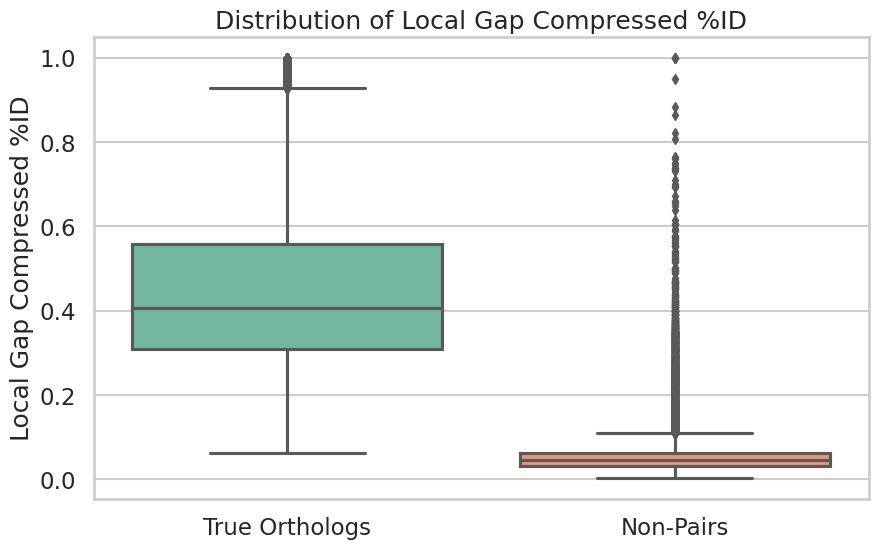

In [8]:
# Prepare data for plotting
data_to_plot = [clean_df['local_gap_compressed_percent_id'], bad_df['local_gap_compressed_percent_id']]

# Create a figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Create the box plot
sns.boxplot(data=data_to_plot, palette="Set2", ax=ax)
ax.set_xticks([0, 1], ['True Orthologs', 'Non-Pairs'])
ax.set_title('Distribution of Local Gap Compressed %ID')
ax.set_ylabel('Local Gap Compressed %ID')

# Show the plot
plt.show()

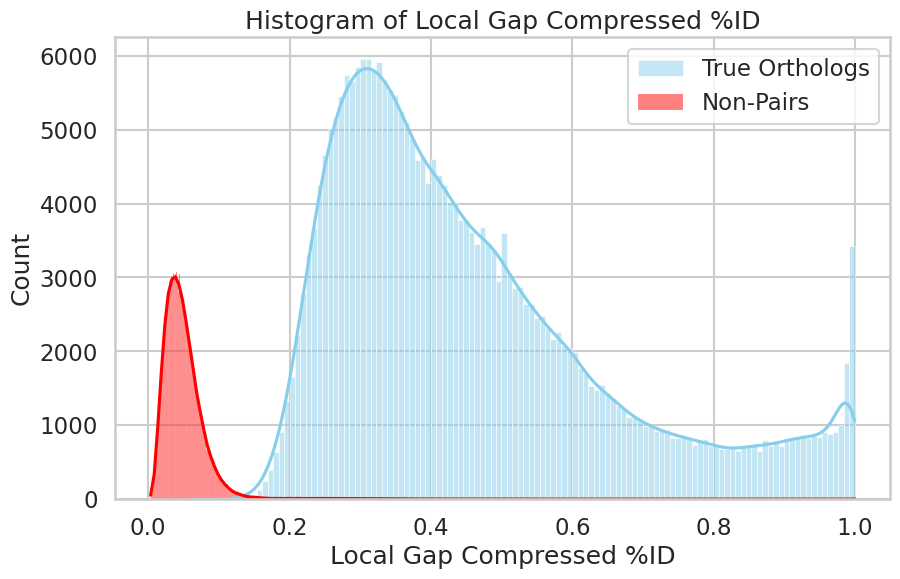

In [9]:
# Create a figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms for both groups
sns.histplot(clean_df['local_gap_compressed_percent_id'], color="skyblue", label='True Orthologs', kde=True)
sns.histplot(bad_df['local_gap_compressed_percent_id'], color="red", label='Non-Pairs', kde=True)

ax.set_title('Histogram of Local Gap Compressed %ID')
ax.set_xlabel('Local Gap Compressed %ID')
ax.legend()

plt.show()

In [10]:
from scipy.stats import mannwhitneyu

For future reference, here is a brief exposition from [wikipedia on this subject](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

In [11]:
# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(clean_df['local_gap_compressed_percent_id'], bad_df['local_gap_compressed_percent_id'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the result
alpha = 0.05  # Set significance level (arbitrary on my end)
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=36273003691.500, p=0.000
Different distribution (reject H0)


Let's do the same analysis for other alignment metrics, which are:

scaled_local_query_percent_id, scaled_local_symmetric_percent_id, query_align_len, query_align_cov, subject_align_len, subject_align_cov

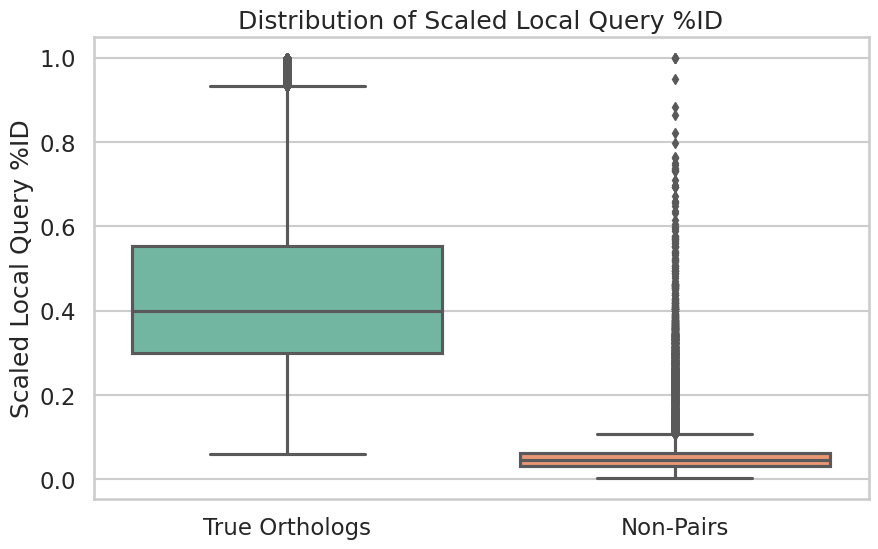

In [12]:
# Prepare data for plotting
data_to_plot = [clean_df['scaled_local_query_percent_id'], bad_df['scaled_local_query_percent_id']]

# Create a figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Create the box plot
sns.boxplot(data=data_to_plot, palette="Set2", ax=ax)
ax.set_xticks([0, 1], ['True Orthologs', 'Non-Pairs'])
ax.set_title('Distribution of Scaled Local Query %ID')
ax.set_ylabel('Scaled Local Query %ID')

# Show the plot
plt.show()

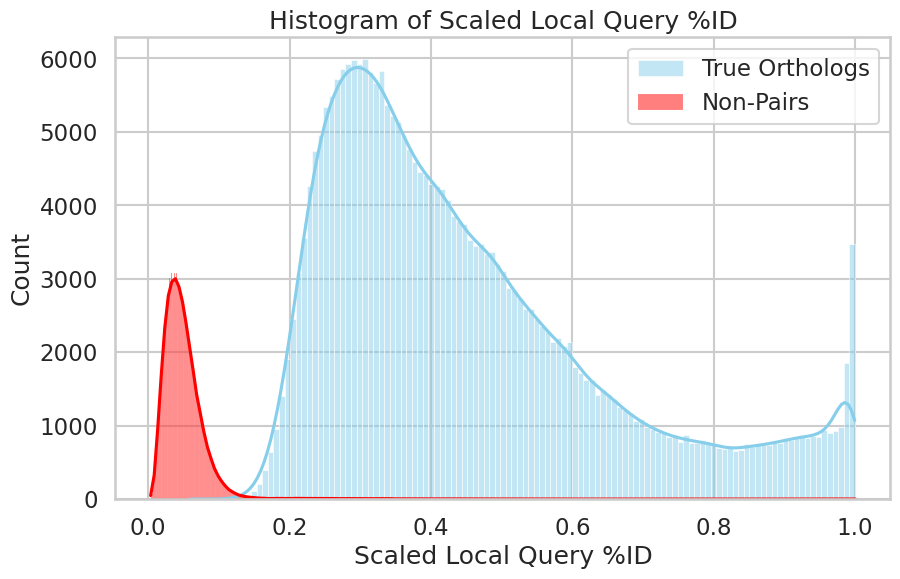

In [13]:
# Create a figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms for both groups
sns.histplot(clean_df['scaled_local_query_percent_id'], color="skyblue", label='True Orthologs', kde=True)
sns.histplot(bad_df['scaled_local_query_percent_id'], color="red", label='Non-Pairs', kde=True)

ax.set_title('Histogram of Scaled Local Query %ID')
ax.set_xlabel('Scaled Local Query %ID')
ax.legend()

plt.show()

In [14]:
# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(clean_df['scaled_local_query_percent_id'], bad_df['scaled_local_query_percent_id'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the result
alpha = 0.05  # Set significance level (arbitrary on my end)
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=36272640341.500, p=0.000
Different distribution (reject H0)


Not sure others will be interesting?

Let's try coverage?

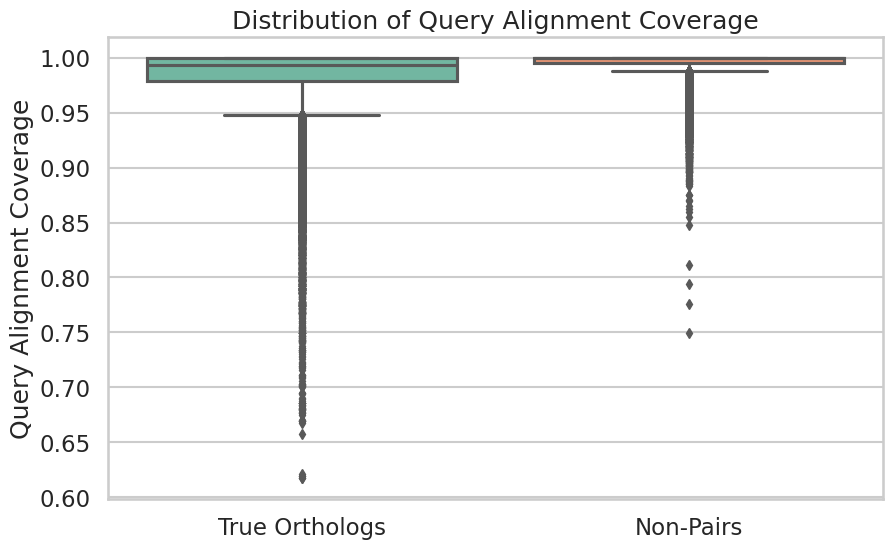

In [15]:
# Prepare data for plotting
data_to_plot = [clean_df['query_align_cov'], bad_df['query_align_cov']]

# Create a figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Create the box plot
sns.boxplot(data=data_to_plot, palette="Set2", ax=ax)
ax.set_xticks([0, 1], ['True Orthologs', 'Non-Pairs'])
ax.set_title('Distribution of Query Alignment Coverage')
ax.set_ylabel('Query Alignment Coverage')

# Show the plot
plt.show()

In [16]:
# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(clean_df['query_align_cov'], bad_df['query_align_cov'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the result
alpha = 0.05  # Set significance level (arbitrary on my end)
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=11884843763.500, p=0.000
Different distribution (reject H0)


LOL

What's next?

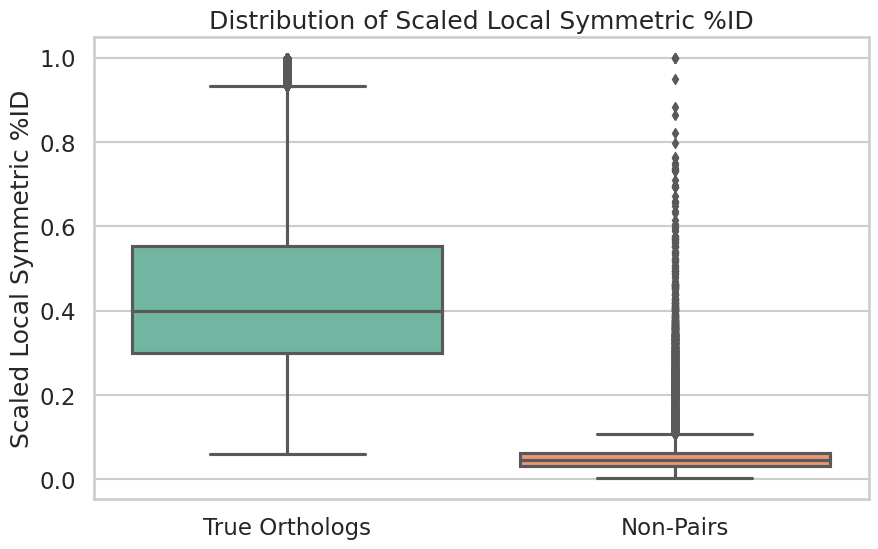

In [17]:
# Prepare data for plotting
data_to_plot = [clean_df['scaled_local_symmetric_percent_id'], bad_df['scaled_local_symmetric_percent_id']]

# Create a figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Create the box plot
sns.boxplot(data=data_to_plot, palette="Set2", ax=ax)
ax.set_xticks([0, 1], ['True Orthologs', 'Non-Pairs'])
ax.set_title('Distribution of Scaled Local Symmetric %ID')
ax.set_ylabel('Scaled Local Symmetric %ID')

# Show the plot
plt.show()

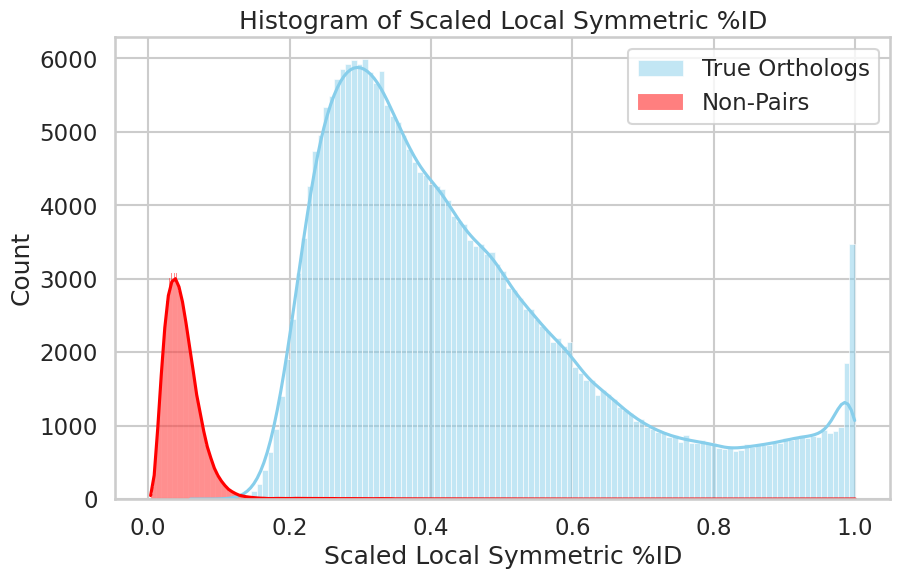

In [19]:
# Create a figure instance
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms for both groups
sns.histplot(clean_df['scaled_local_symmetric_percent_id'], color="skyblue", label='True Orthologs', kde=True)
sns.histplot(bad_df['scaled_local_symmetric_percent_id'], color="red", label='Non-Pairs', kde=True)

ax.set_title('Histogram of Scaled Local Symmetric %ID')
ax.set_xlabel('Scaled Local Symmetric %ID')
ax.legend()

plt.show()

In [18]:
# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(clean_df['scaled_local_symmetric_percent_id'], bad_df['scaled_local_symmetric_percent_id'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the result
alpha = 0.05  # Set significance level (arbitrary on my end)
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=36272640341.500, p=0.000
Different distribution (reject H0)


Yeah all metrics are roughly equivalent

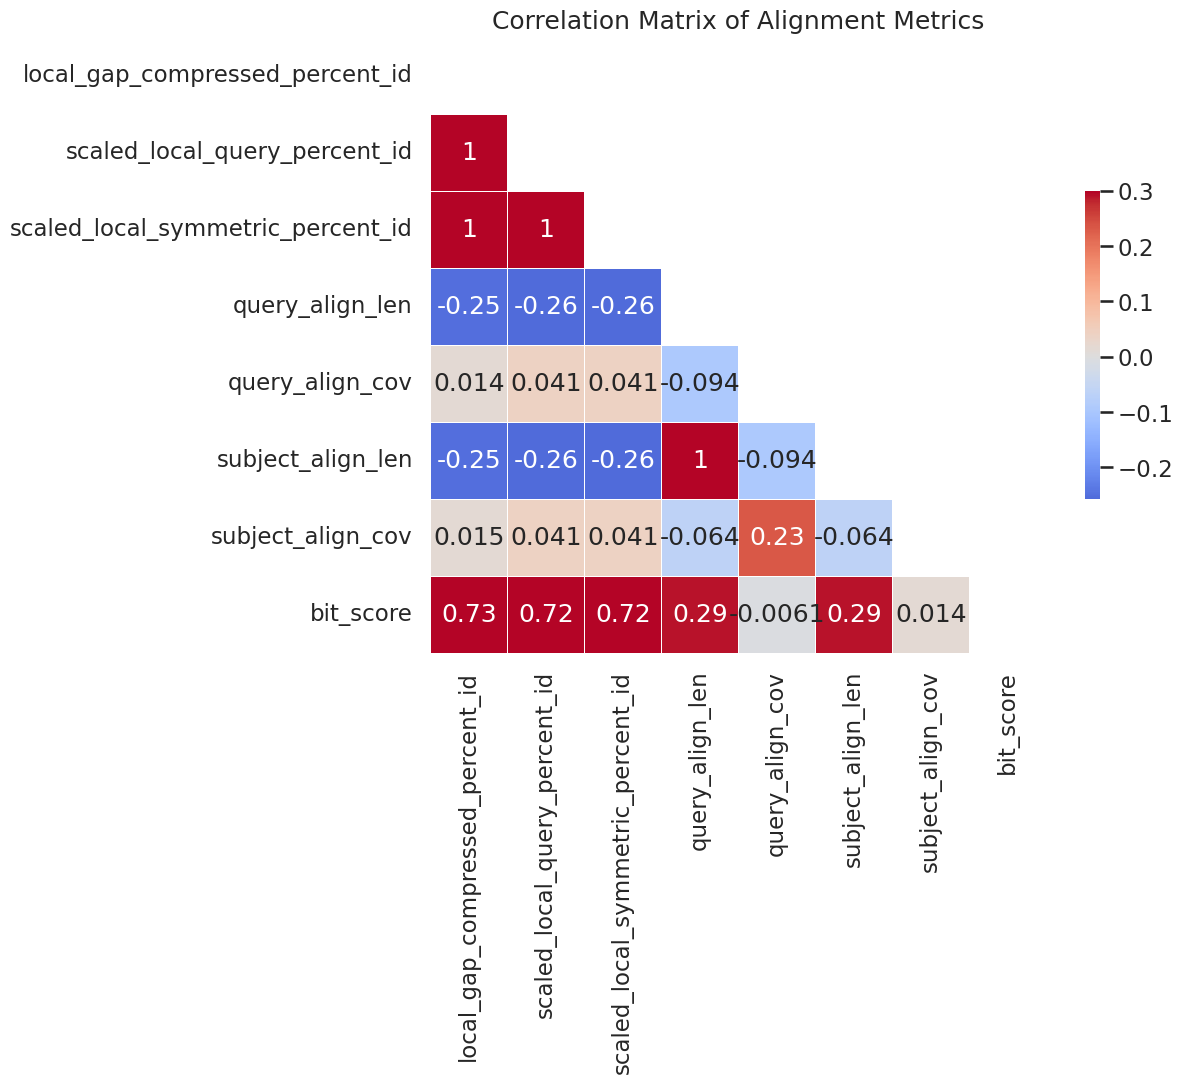

In [19]:
# Select columns for correlation analysis
metrics = ['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 
           'scaled_local_symmetric_percent_id', 'query_align_len', 
           'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score']

# Compute the correlation matrix
corr_matrix = data[metrics].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Matrix of Alignment Metrics')
plt.show()

Do I need more features to discriminate pairs and non-pairs via OMA?

Let's assume the simpliest/toy example

```py
def classify_pair(local_gap_id, query_percent_id, local_gap_threshold, query_percent_threshold):
    if local_gap_id > local_gap_threshold and query_percent_id > query_percent_threshold:
        return 'True Pair'
    else:
        return 'Non-Pair'
```

### Classifications

In [10]:
#### ATTEMPT

def classify_pair(local_gap_id, query_percent_id, local_gap_threshold, query_percent_threshold):
    if local_gap_id > local_gap_threshold and query_percent_id > query_percent_threshold:
        return 'True Pair'
    else:
        return 'Non-Pair'

# Example thresholds determined from your analysis
local_gap_threshold = 0.6  # Hypothetical value
query_percent_threshold = 0.6  # Hypothetical value

# Apply the classification function to each pair in the DataFrame
data['classification'] = data.apply(lambda x: classify_pair(x['local_gap_compressed_percent_id'], 
                                                        x['scaled_local_query_percent_id'], 
                                                        local_gap_threshold, 
                                                        query_percent_threshold), axis=1)

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
# Need to true label for confusion matrix
data['true_labels'] = data['pair_id'].apply(lambda x: 'True Pair' if 'clean_' in x else 'Non-Pair')

In [13]:
data

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,pair_id,protein1_uniprot_id,protein2_uniprot_id,protein1_alphafold_id,protein2_alphafold_id,classification,true_labels
0,0.633411,0.631944,0.631944,432,0.995370,432,0.995370,1381.0,clean_1,Q6GG31,A0A0L9Z481,Q6GG31,A0A0L9Z481,True Pair,True Pair
1,0.569412,0.566745,0.566745,427,0.988290,427,0.997658,1224.0,clean_2,Q6GG31,A0A2T7B9D1,Q6GG31,A0A2T7B9D1,Non-Pair,True Pair
2,0.260586,0.260586,0.260586,307,0.990228,307,1.000000,305.0,clean_3,A0A0M9XI34,A0A6L8P192,A0A0M9XI34,A0A6L8P192,Non-Pair,True Pair
3,0.392308,0.376384,0.376384,271,0.970480,271,0.974170,434.0,clean_4,Q4L904,A0A643CKU9,Q4L904,A0A643CKU9,Non-Pair,True Pair
4,0.298450,0.296154,0.296154,260,0.992308,260,0.992308,330.0,clean_5,Q4L8Y1,A0A427NXW7,Q4L8Y1,A0A427NXW7,Non-Pair,True Pair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402146,0.044586,0.044211,0.044211,475,1.000000,475,0.983158,40.0,bad_137006,A0A2A1KDX2,Q4AAJ3,A0A1J0SPD3,Q0I144,Non-Pair,Non-Pair
402147,0.043103,0.043103,0.043103,464,1.000000,464,0.997845,42.0,bad_137039,A0A4Q9W971,A0A380SBW5,A0A064BZM9,A0A379SJQ6,Non-Pair,Non-Pair
402148,0.056034,0.056034,0.056034,232,1.000000,232,1.000000,29.0,bad_137061,A0A0B6TQ36,A0A045JBZ6,Q2GE03,A0A447M395,Non-Pair,Non-Pair
402149,0.036649,0.036458,0.036458,576,1.000000,576,0.993056,29.0,bad_137119,A0A0B8QRQ5,A0A663D6L2,C3TM52,A0A0T6TFB4,Non-Pair,Non-Pair


**Repeat the exercise with different values**

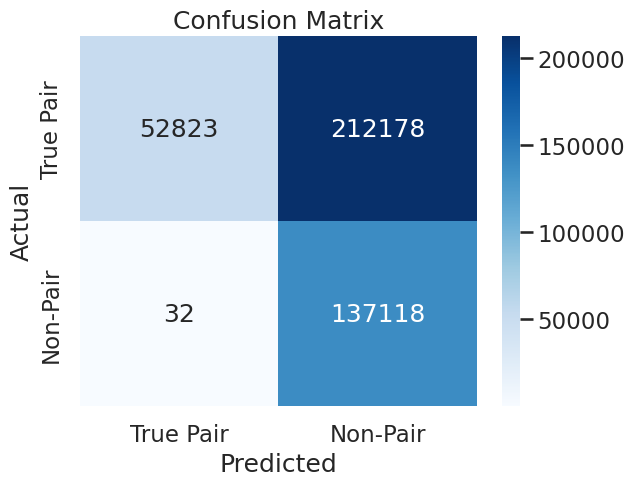

In [14]:
# Classifications ('True Pair', 'Non-Pair')
true_labels = data['true_labels']  # Validation set
predicted_labels = data['classification']  # "predicted" classification

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['True Pair', 'Non-Pair'])

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['True Pair', 'Non-Pair'], yticklabels=['True Pair', 'Non-Pair'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Calculate precision, recall, and F1 score
report = classification_report(true_labels, predicted_labels, target_names=['True Pair', 'Non-Pair'])
print(report)

              precision    recall  f1-score   support

   True Pair       0.39      1.00      0.56    137150
    Non-Pair       1.00      0.20      0.33    265001

    accuracy                           0.47    402151
   macro avg       0.70      0.60      0.45    402151
weighted avg       0.79      0.47      0.41    402151



Tomorrow

## 02-26-24

- Noticed that %ID are generally very low (could be due to bit scores)
  - Let's plot the histograms
- majority are low...  

In [16]:
pctid = data["local_gap_compressed_percent_id"]

The max value for local gap compressed percent id = 1.0


Text(0, 0.5, 'Count')

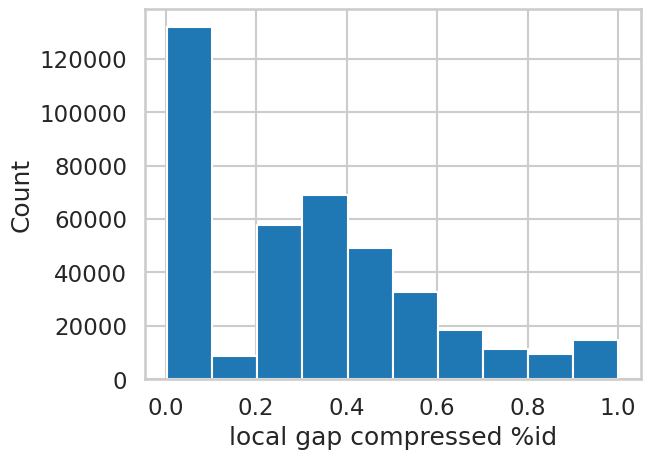

In [17]:
print(f"The max value for local gap compressed percent id = {max(pctid.values)}")

plt.hist(pctid)
plt.xlabel("local gap compressed %id")
plt.ylabel("Count")

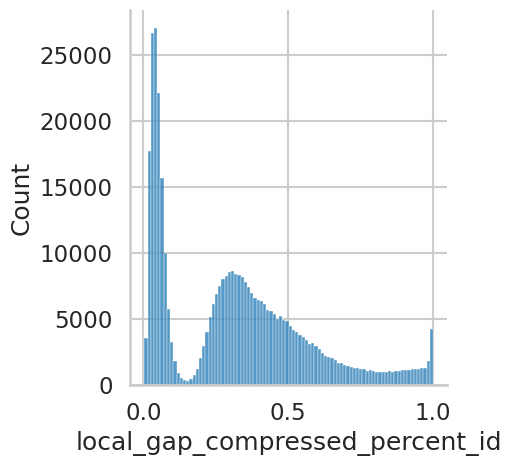

In [18]:
sns.displot(data = data, x = "local_gap_compressed_percent_id")

The max value for local gap compressed percent id = 22121.0


Text(0, 0.5, 'Count')

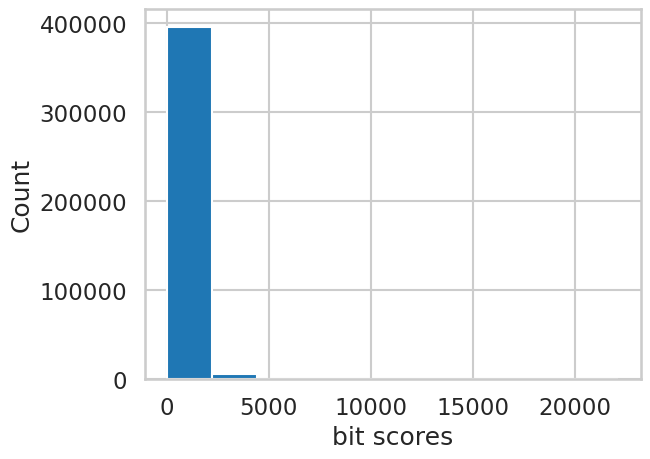

In [19]:
bitscores = data["bit_score"]
print(f"The max value for local gap compressed percent id = {max(bitscores.values)}")

plt.hist(bitscores)
plt.xlabel("bit scores")
plt.ylabel("Count")

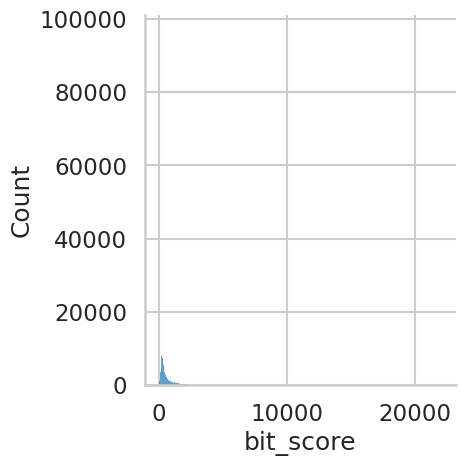

In [20]:
sns.displot(data = data, x = "bit_score")

Bit score needs to be normalized

- Random sequence from uniprot
- Both are human proteins.

seq_1 = P05067 (Amyloid-beta precursor protein)
seq_2 = P31946 (14-3-3 protein beta/alpha)

The max value for local gap compressed percent id = 5.907407407407407


Text(0, 0.5, 'Count')

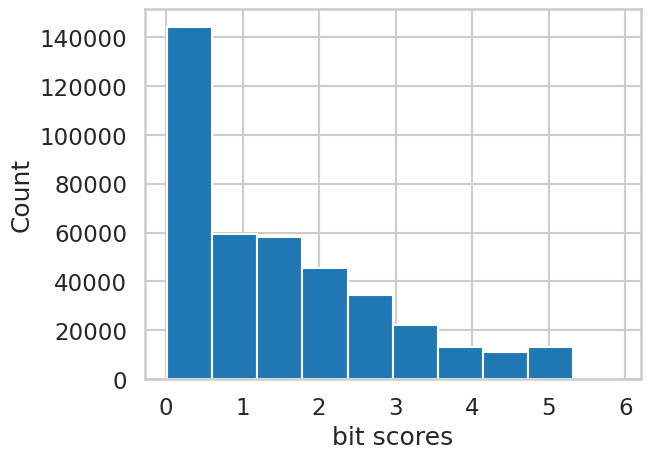

In [21]:
bitscores = data["bit_score"]/data["query_align_len"] # normalized with query alignment length
print(f"The max value for local gap compressed percent id = {max(bitscores.values)}")

plt.hist(bitscores)
plt.xlabel("bit scores")
plt.ylabel("Count")

### Sanity checkes

In [52]:
sequence_1 = "MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHPHFVIPYRCLVGEFVSDALLVPDKCKFLHQERMDVCETHLHWHTVAKETCSEKSTNLHDYGMLLPCGIDKFRGVEFVCCPLAEESDNVDSADAEEDDSDVWWGGADTDYADGSEDKVVEVAEEEEVAEVEEEEADDDEDDEDGDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSAMSQSLLKTTQEPLARDPVKLPTTAASTPDAVDKYLETPGDENEHAHFQKAKERLEAKHRERMSQVMREWEEAERQAKNLPKADKKAVIQHFQEKVESLEQEAANERQQLVETHMARVEAMLNDRRRLALENYITALQAVPPRPRHVFNMLKKYVRAEQKDRQHTLKHFEHVRMVDPKKAAQIRSQVMTHLRVIYERMNQSLSLLYNVPAVAEEIQDEVDELLQKEQNYSDDVLANMISEPRISYGNDALMPSLTETKTTVELLPVNGEFSLDDLQPWHSFGADSVPANTENEVEPVDARPAADRGLTTRPGSGLTNIKTEEISEVKMDAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIATVIVITLVMLKKKQYTSIHHGVVEVDAAVTPEERHLSKMQQNGYENPTYKFFEQMQN"

In [51]:
sequence_2 = "MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLLSVAYKNVVGARRSSWRVISSIEQKTERNEKKQQMGKEYREKIEAELQDICNDVLELLDKYLIPNATQPESKVFYLKMKGDYFRYLSEVASGDNKQTTVSNSQQAYQEAFEISKKEMQPTHPIRLGLALNFSVFYYEILNSPEKACSLAKTAFDEAIAELDTLNEESYKDSTLIMQLLRDNLTLWTSENQGDEGDAGEGEN"

In [53]:
from Bio import Align
from Bio.Align import substitution_matrices

In [59]:
# Example testing than I will test out my function again
aligner = Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
alignments = aligner.align(sequence_1, sequence_2)

In [63]:
alignments[0]

In [64]:
alignments[0].score

804.0

So....Why isn't it working?

In [62]:
print(alignments[0])

MLPGLALLLLAAWTARALEVPTDG-NAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSGTKTCIDTK-EGILQYCQ-EV-YPE-LQ---ITNVVEANQPVTI-QNWCKRGRKQCKTHPHFVIPYRCLVGEFVSDALLVPDKCKFLHQER-MDVCETHLHWHTVA-KETCSEKSTNLHDYGMLLPCGID-KFRGVEFVCCPLAEESDNVDSADAEEDDSDVWWGGADTDYADGSEDKVVE--VAEEE-EVA--EVEEEEADDDEDDED-GDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSAMSQSLLKTTQEPLAR-DPVK-L-PTT-AAST-PDAVDK--YLETP--GDENEHAHFQKAKER-LEAKHRERMSQVMREWEEA--ERQAKNLPKADKKAVIQHFQEK--VESLEQEAANER-QQLVETHMARVEAMLNDRRRLALENYITALQ-AVPPRPRHVFNMLKKYVRAEQ--KDRQHTLKHFEHVRMVD-PKKAAQIRSQVMTHLRV-IYERMNQSLS-L-LYNVP-AVAEEIQDEVDELLQKEQN-YS-DDVLANMISEPRISYGND-ALMP-SLTET-KTTVELLPVNGE-FSLDDLQPWHSFGADSVPANTENEVEPVDARPAADRGLTTRPGSGLTNIKTEEISEV-KMDAEFRHDSGYE--VHH-QKLVFFAE-DVGSNKGAIIGLMVGGVVIATVIVITLVMLKKKQYTSI-HH-GVV-EV-DAAVTP-EERHLSKMQQNGYENPTYKFFEQMQN
|------------|---.----|--.-----|---------|-----||--|--.-----|--.----|---|----|--|-.-.----.----.|---||--|-----|------|------------|-.|.-----.-------||-.------|---.||-|------

We know that this set up works, but why doesn't it work in the BLAST function?

In [84]:
quick_dict = {'pair_id': [42069], 'protein1_uniprot_id': [101], 'protein2_uniprot_id': [202], 'protein1_sequence': [sequence_1], 'protein2_sequence': [sequence_2]}

In [85]:
test_dataframe = pd.DataFrame.from_dict(quick_dict)
test_dataframe

,pair_id,protein1_uniprot_id,protein2_uniprot_id,protein1_sequence,protein2_sequence
0,42069,101,202,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...


In [89]:
check_df, con = pp_ub.make_blast_df(test_dataframe, 2, path='blast_db.db')
check_df

,pair_id,protein1_uniprot_id,protein2_uniprot_id,query,subject,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score
0,42069,101,202,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,0.036437,0.011688,0.011688,770,1.0,770,0.319481,0.0


In [90]:
con.close()

Wait...How do they have the same align len?!?!

Hmmm. Let's "sanity-check" other metrics

In [110]:
data.iloc[:1]

,pair_id,protein1_uniprot_id,protein2_uniprot_id,query,subject,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id,classification,true_labels
0,clean_1,A8MLB2,A0A375GY15,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALL...,0.088608,0.08284,0.08284,169,0.928994,169,1.0,0.0,A8MLB2,A0A375GY15,Non-Pair,True Pair


In [112]:
len(data.iloc[1]["query"])

157

...

### Debugging BLAST once again

1) Turns out the thing wasn't working correctly
2) Let's take the code bit-by-bit from the function and test it out
3) We will assume that checking of the dataframe works

In [4]:
class PicklablePairwiseAligner(Align.PairwiseAligner):
    def __getstate__(self):
        return
    def __setstate__(self, state):
        return

In [5]:
class PicklablePairwiseAligner(Align.PairwiseAligner):
    def __init__(self, *args, **kwargs):
        # Directly set the 'config' attribute to bypass PairwiseAligner's __setattr__
        object.__setattr__(self, 'config', {
            "substitution_matrix": substitution_matrices.load("BLOSUM62"),
            "open_gap_score": -11,
            "extend_gap_score": -1,
            "mode": "local"
        })
        
        # Now call the superclass constructor
        super().__init__(*args, **kwargs)
        
        # Apply the configuration settings
        self.configure_aligner()

    def configure_aligner(self):
        # Apply the settings from the config
        self.substitution_matrix = self.config['substitution_matrix']
        self.open_gap_score = self.config['open_gap_score']
        self.extend_gap_score = self.config['extend_gap_score']
        self.mode = self.config['mode']

    def __getstate__(self):
        # Customize what gets pickled, if necessary
        state = self.__dict__.copy()
        # Remove unpicklable entries if necessary
        return state

    def __setstate__(self, state):
        # Restore instance attributes
        self.__dict__.update(state)
        # Re-apply the configuration upon unpickling
        self.configure_aligner()

In [5]:
# Biopython alignment settings
aligner = PicklablePairwiseAligner()
# aligner.configure_aligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.open_gap_score = -11
aligner.extend_gap_score = -1
aligner.mode = "local"

In [6]:
# Metrics to be calculated
metrics = ['local_gap_compressed_percent_id',
               'scaled_local_query_percent_id',
               'scaled_local_symmetric_percent_id',
               'query_align_len',
               'query_align_cov',
               'subject_align_len',
               'subject_align_cov',
               'bit_score']

# Iterate through all pairs and calculate best alignment and metrics
cols = metrics + ['pair_id', 'protein1_uniprot_id', 'protein2_uniprot_id']
final_data = pd.DataFrame(columns=cols)

In [9]:
# Let's make 100 row sample from the data
test_case = data[:100]
test_case

,pair_id,protein1_uniprot_id,protein2_uniprot_id,query,subject,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id
0,clean_1,A8MLB2,A0A375GY15,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALL...,0.088608,0.082840,0.082840,169,0.928994,169,1.000000,0.0,A8MLB2,A0A375GY15
1,clean_2,A8MLB2,V5VDW9,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MVAQIRIGQGMDVHAFEEGNFVTLAGVQIPHTHGLKAHSDGDVVLH...,0.063291,0.062500,0.062500,160,0.981250,160,1.000000,0.0,A8MLB2,V5VDW9
2,clean_3,A8MLB2,A0A3R0GDC6,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MRIGHGFDVHAFGGEGPIIIGGVRISYEKGLLAHSDGDVALHALTD...,0.101266,0.100629,0.100629,159,0.987421,159,1.000000,0.0,A8MLB2,A0A3R0GDC6
3,clean_4,A0A7U2SIP4,A0A4R3ZSL4,MIKATNIQKNYDTLQVLKGVNLHIEKGEIISIVGASGAGKTTLLQI...,MIVHLFFRGFPELADLVLQASGIAKSFGGNEVLKGLSLDVERGELI...,0.049774,0.041667,0.041667,264,0.833333,264,1.000000,0.0,A0A7U2SIP4,A0A4R3ZSL4
4,clean_5,A0A7U2SIP4,Q3L7K3,MIKATNIQKNYDTLQVLKGVNLHIEKGEIISIVGASGAGKTTLLQI...,MMQSAGIVVNDVTVTWRNGHTALRDASFTVPGGSIAALVGVNGSGK...,0.072398,0.058182,0.058182,275,0.800000,275,1.000000,0.0,A0A7U2SIP4,Q3L7K3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,clean_96,A0A2R7DZP3,P0AAT6,MDSKQLLEMVVKAADGRRAEDIIALKVDEISPMADYFVIMTGGSDR...,MQGKALQDFVIDKIDDLKGQDIIALDVQGKSSITDCMIICTGTSSR...,0.094340,0.084746,0.084746,118,1.000000,118,0.889831,0.0,A0A2R7DZP3,P0AAT6
96,clean_97,A0A5V4GS88,A0A380PNP6,MIFTLRPYQQEAVDATLSHFRRHRTPAVIVLPTGAGKSLVIAELAR...,MAFTLRPYQREAVDATVAYFRRHTTPALIVLPTGAGKSLVIAELAK...,0.075085,0.075085,0.075085,586,1.000000,586,0.998294,0.0,A0A5V4GS88,A0A380PNP6
97,clean_98,A0A5H9MUW1,A0A0D6FDL4,MPEVTPFQVLIVDDHPLMRRGIRQLLELDPAFYVVAEAGDGASAID...,MPEVTPFQVLIVDDHPLMRRGIRQLLELDPAFHVVAEAGDGASAID...,0.995349,0.995349,0.995349,215,1.000000,215,1.000000,0.0,A0A5H9MUW1,A0A0D6FDL4
98,clean_99,A0A3U4AP74,RSUA_YERPE,MRLDKFIAQQLGVSRAIAGREIRGNRVTVDGDIIKNAAFKLLPEHA...,MRLDKFLSQQLGVSRALVARELRAKRVTIDGEVVKSGAIKLTPEQD...,0.047414,0.046809,0.046809,235,0.982979,235,1.000000,0.0,A0A3U4AP74,RSUA_YERPE


In [7]:
# Alignment functions (assume they're right)
def get_matches_gaps(query, subject):
    """
    Parses sequence alignment text to calculate the number of matches, gaps,
    compressed gaps, and total columns.

    Args:
        query (str): Query aligned sequence.
        subject (str): Subject aligned sequence.

    Returns:
        n_matches (int): Number of matching amino acids in the sequence
                         alignment.
        n_gaps (int): Total number of gaps across both aligned sequences.
        n_columns (int): Length of the aligned query sequence.
        n_comp_gaps (int): Number of compressed gaps.
    """
    n_columns = len(query)
    n_gaps = sum(i == '-' for i in query) + sum(i == '-' for i in subject)
    n_matches = sum(i == j and i != '-' for i, j in zip(query, subject))
    pattern = r'(-{1,})'

    instances = re.findall(pattern, query) + re.findall(pattern, subject)
    n_comp_gaps = len(instances)

    return n_matches, n_gaps, n_columns, n_comp_gaps


def gap_compressed_percent_id(n_matches, n_gaps, n_columns, n_comp_gaps):
    """
    Calculates the percent id with compressed gaps.

    Args:
        n_matches (int): Number of matches in match columns
        n_gaps (int): Number of gaps in match columns
        n_columns (int): Total number of alignment match columns
        n_compressed_gaps (int): Number of compressed gaps in match columns

    Returns:
        n_matches / (n_columns - n_gaps + n_comp_gaps)
    """
    return n_matches / (n_columns - n_gaps + n_comp_gaps)


def sequence_validate(seq, alph):
    """
    Makes sure sequence complies with alphabet.

    Args:
        seq (int): Number of matches in match columns
        alph (int): Number of gaps in match columns

    Returns:
        (bool): True if sequence is valid, False if not
    """
    extra = set(seq) - alph
    return not extra

**Check**

In [26]:
def aligner_align(row, aligner):


    # subject = row[1]['subject']
    # query = row[1]['query']
    # print(row)
    index, data = row  # Unpack the tuple into index and data (Series)
    subject = data['subject']
    query = data['query']
    # print(type(data))
    # print(f'subject protein: {type(subject)}')
    # print(f'query protein: {type(query)}')

    alignment = aligner.align(query, subject)
    best_alignment = max(alignment, key=lambda x: x.score)

    alignment_str = format(best_alignment)
    alignment_lines = alignment_str.split('\n')

    seq1_aligned = alignment_lines[0]
    seq2_aligned = alignment_lines[2]

    # Coverage and sequence length
    subject_cov = sum(c != '-' for c in seq2_aligned)
    query_cov = sum(c != '-' for c in seq1_aligned)
    subject_length = len(seq2_aligned)
    query_length = len(seq1_aligned)
    subject_cov /= subject_length
    query_cov /= query_length

    # Percent ids
    n_matches, n_gaps, n_columns, n_comp_gaps = get_matches_gaps(
        seq2_aligned, seq1_aligned)
    gap_comp_pct_id = gap_compressed_percent_id(
        n_matches, n_gaps, n_columns, n_comp_gaps)
    scaled_local_symmetric_percent_id = 2*n_matches / (subject_length + query_length)
    scaled_local_query_percent_id = n_matches / query_length

    # Collect calculated metrics into a list for addition to final_data
    new_row = [gap_comp_pct_id, scaled_local_query_percent_id,
            scaled_local_symmetric_percent_id, query_length,
            query_cov, subject_length, subject_cov, best_alignment.score,
            data['pair_id'], data['protein1_uniprot_id'], data['protein2_uniprot_id']]
    return new_row

In [8]:
# Parallel(n_jobs=2)(delayed(aligner_align)(row, aligner) for row in test_case.iterrows())

PicklingError: Could not pickle the task to send it to the workers.

Let me define a class, which makes it pickable! (Added to a cell before align error)
Similar [error](https://stackoverflow.com/questions/8804830/python-multiprocessing-picklingerror-cant-pickle-type-function)

In [12]:
wow_1 = Parallel(n_jobs=2)(delayed(aligner_align)(row, aligner) for row in test_case.iterrows())

In [80]:
type(wow_1)

list

In [13]:
pd.DataFrame(wow_1, columns=cols)

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,pair_id,protein1_uniprot_id,protein2_uniprot_id
0,0.088608,0.082840,0.082840,169,0.928994,169,1.000000,0.0,clean_1,A8MLB2,A0A375GY15
1,0.063291,0.062500,0.062500,160,0.981250,160,1.000000,0.0,clean_2,A8MLB2,V5VDW9
2,0.101266,0.100629,0.100629,159,0.987421,159,1.000000,0.0,clean_3,A8MLB2,A0A3R0GDC6
3,0.049774,0.041667,0.041667,264,0.833333,264,1.000000,0.0,clean_4,A0A7U2SIP4,A0A4R3ZSL4
4,0.072398,0.058182,0.058182,275,0.800000,275,1.000000,0.0,clean_5,A0A7U2SIP4,Q3L7K3
...,...,...,...,...,...,...,...,...,...,...,...
95,0.094340,0.084746,0.084746,118,1.000000,118,0.889831,0.0,clean_96,A0A2R7DZP3,P0AAT6
96,0.075085,0.075085,0.075085,586,1.000000,586,0.998294,0.0,clean_97,A0A5V4GS88,A0A380PNP6
97,0.995349,0.995349,0.995349,215,1.000000,215,1.000000,0.0,clean_98,A0A5H9MUW1,A0A0D6FDL4
98,0.047414,0.046809,0.046809,235,0.982979,235,1.000000,0.0,clean_99,A0A3U4AP74,RSUA_YERPE


#### Confidence Test(s)

In [33]:
type(test_case["subject"])

pandas.core.series.Series

In [34]:
type(test_case["query"])

pandas.core.series.Series

In [35]:
len(test_case["query"].iloc[0])

157

That's right. Hmmm. (aligned seq lenth)

In [41]:
protein1 = test_case["query"].iloc[0]
protein2 = test_case["subject"].iloc[0]
print(protein1)
print('\n')
print(protein2)

MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKDAILGAAALGDIGKHFPDTDERYKGANSLELLKEVSNLIKSKGYKIHNLDATIIAQKPKMASHIEQMRANIAAAINVDMDSVNVKATTTEGLGFVGVGEGIAANAIASIIKA


MMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALLHAVTDALFGAAALGDIGRHFPDTDAQFAGADSRALLREAARRVREAGYEIGNVDATVIAQAPKLAPHIGAMVANLAEDLAIARGRCNVKAKTNEKLGFEGRQEGIVAQAAVLLWRASVADAQD


In [45]:
alignment = aligner.align(protein1, protein2)
best_alignment = max(alignment, key=lambda x: x.score)

alignment_str = format(best_alignment)
alignment_lines = alignment_str.split('\n')

seq1_aligned = alignment_lines[0]
seq2_aligned = alignment_lines[2]

In [43]:
alignment_str

'     MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKDAILGAAALGDIGKHFPDTDERYKGANSLELLKEVSNLIKSKGYKIHNLDATIIAQKPKMASHIEQMRANIAAAINVDMDSVNVKATTTEGLGFVGVGEGIAANAIASIIKA       \n     .|||.|||||.||..||||.|||.||...|||||||||.||||..||..|||||||||.||||||....||.|..||.|........||.|.|.|||.|||.||.|.||..|.||.|..........||||.|.|.|||.|..|||.|.|......|       \nMMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALLHAVTDALFGAAALGDIGRHFPDTDAQFAGADSRALLREAARRVREAGYEIGNVDATVIAQAPKLAPHIGAMVANLAEDLAIARGRCNVKAKTNEKLGFEGRQEGIVAQAAVLLWRASVADAQD\n'

In [44]:
alignment_lines

['     MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKDAILGAAALGDIGKHFPDTDERYKGANSLELLKEVSNLIKSKGYKIHNLDATIIAQKPKMASHIEQMRANIAAAINVDMDSVNVKATTTEGLGFVGVGEGIAANAIASIIKA       ',
 '     .|||.|||||.||..||||.|||.||...|||||||||.||||..||..|||||||||.||||||....||.|..||.|........||.|.|.|||.|||.||.|.||..|.||.|..........||||.|.|.|||.|..|||.|.|......|       ',
 'MMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALLHAVTDALFGAAALGDIGRHFPDTDAQFAGADSRALLREAARRVREAGYEIGNVDATVIAQAPKLAPHIGAMVANLAEDLAIARGRCNVKAKTNEKLGFEGRQEGIVAQAAVLLWRASVADAQD',
 '']

In [46]:
seq1_aligned

'     MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKDAILGAAALGDIGKHFPDTDERYKGANSLELLKEVSNLIKSKGYKIHNLDATIIAQKPKMASHIEQMRANIAAAINVDMDSVNVKATTTEGLGFVGVGEGIAANAIASIIKA       '

In [47]:
seq2_aligned

'MMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALLHAVTDALFGAAALGDIGRHFPDTDAQFAGADSRALLREAARRVREAGYEIGNVDATVIAQAPKLAPHIGAMVANLAEDLAIARGRCNVKAKTNEKLGFEGRQEGIVAQAAVLLWRASVADAQD'

In [49]:
best_alignment.score

457.0

In [54]:
 # Coverage and sequence length
subject_cov = sum(c != '-' for c in seq2_aligned)
query_cov = sum(c != '-' for c in seq1_aligned)
subject_length = len(seq2_aligned)
query_length = len(seq1_aligned)
subject_cov /= subject_length
query_cov /= query_length

# Percent ids
n_matches, n_gaps, n_columns, n_comp_gaps = get_matches_gaps(
    seq2_aligned, seq1_aligned)
gap_comp_pct_id = gap_compressed_percent_id(
    n_matches, n_gaps, n_columns, n_comp_gaps)
scaled_local_symmetric_percent_id = 2*n_matches / (subject_length + query_length)
scaled_local_query_percent_id = n_matches / query_length

In [55]:
subject_cov

1.0

In [56]:
query_cov

1.0

In [57]:
subject_length

169

In [58]:
query_length

169

In [59]:
gap_comp_pct_id

0.5325443786982249

In [60]:
scaled_local_query_percent_id

0.5325443786982249

In [61]:
scaled_local_query_percent_id

0.5325443786982249

wtf

**Testing loop.**

In [82]:
# Initialize an empty list to store the results
final_data = []

# Loop over each row in the DataFrame
for index, row in test_case.iterrows():
    # Call the aligner_align function with each row
    result = aligner_align((index, row), aligner)
    # Append the result to the final_data list
    final_data.append(result)

In [85]:
pd.DataFrame(final_data, columns=cols)

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,pair_id,protein1_uniprot_id,protein2_uniprot_id
0,0.532544,0.532544,0.532544,169,1.000000,169,1.000000,457.0,clean_1,A8MLB2,A0A375GY15
1,0.484472,0.484472,0.484472,161,1.000000,161,1.000000,400.0,clean_2,A8MLB2,V5VDW9
2,0.616352,0.616352,0.616352,159,1.000000,159,1.000000,485.0,clean_3,A8MLB2,A0A3R0GDC6
3,0.288973,0.285714,0.285714,266,0.981203,266,0.992481,328.0,clean_4,A0A7U2SIP4,A0A4R3ZSL4
4,0.184116,0.180851,0.180851,282,0.992908,282,0.975177,149.0,clean_5,A0A7U2SIP4,Q3L7K3
...,...,...,...,...,...,...,...,...,...,...,...
95,0.381356,0.381356,0.381356,118,1.000000,118,1.000000,229.0,clean_96,A0A2R7DZP3,P0AAT6
96,0.776451,0.776451,0.776451,586,1.000000,586,1.000000,2465.0,clean_97,A0A5V4GS88,A0A380PNP6
97,0.995349,0.995349,0.995349,215,1.000000,215,1.000000,1053.0,clean_98,A0A5H9MUW1,A0A0D6FDL4
98,0.800000,0.800000,0.800000,235,1.000000,235,1.000000,1013.0,clean_99,A0A3U4AP74,RSUA_YERPE


In [90]:
dir(substitution_matrices)

['Array',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__warningregistry__',
 'load',
 'numpy',
 'os',
 'read',
 'string']

In [99]:
aligner

Pairwise aligner, implementing the Needleman-Wunsch, Smith-Waterman, Gotoh, and Waterman-Smith-Beyer global and local alignment algorithms

In [105]:
lambda_val = 0.3176  # Example value for BLOSUM62, adjust based on actual value
K_val = 0.134  # Example value for BLOSUM62, adjust based on actual value

In [106]:
(lambda_val * 457.0 - math.log(K_val))/math.log(2)

212.29706995295933

Close to the BLAST online calc

prefer="threads"

In [16]:
from joblib import wrap_non_picklable_objects

In [52]:
def aligner_align(row, aligner):


    # subject = row[1]['subject']
    # query = row[1]['query']
    # print(row)
    index, data = row  # Unpack the tuple into index and data (Series)
    subject = data['subject']
    query = data['query']
    # print(type(data))
    # print(f'subject protein: {type(subject)}')
    # print(f'query protein: {type(query)}')

    alignment = aligner.align(query, subject)
    best_alignment = max(alignment, key=lambda x: x.score)

    alignment_str = format(best_alignment)
    alignment_lines = alignment_str.split('\n')

    seq1_aligned = alignment_lines[0]
    seq2_aligned = alignment_lines[2]

    # Coverage and sequence length
    subject_cov = sum(c != '-' for c in seq2_aligned)
    query_cov = sum(c != '-' for c in seq1_aligned)
    subject_length = len(seq2_aligned)
    query_length = len(seq1_aligned)
    subject_cov /= subject_length
    query_cov /= query_length

    # Percent ids
    n_matches, n_gaps, n_columns, n_comp_gaps = get_matches_gaps(
        seq2_aligned, seq1_aligned)
    gap_comp_pct_id = gap_compressed_percent_id(
        n_matches, n_gaps, n_columns, n_comp_gaps)
    scaled_local_symmetric_percent_id = 2*n_matches / (subject_length + query_length)
    scaled_local_query_percent_id = n_matches / query_length

    # Collect calculated metrics into a list for addition to final_data
    new_row = [gap_comp_pct_id, scaled_local_query_percent_id,
            scaled_local_symmetric_percent_id, query_length,
            query_cov, subject_length, subject_cov, best_alignment.score,
            data['pair_id'], data['protein1_uniprot_id'], data['protein2_uniprot_id']]
    return new_row

In [8]:
# Let's make 100 row sample from the data
test_case = data[:10000]
test_case

,pair_id,protein1_uniprot_id,protein2_uniprot_id,query,subject,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id
0,clean_1,A8MLB2,A0A375GY15,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALL...,0.088608,0.082840,0.082840,169,0.928994,169,1.000000,0.0,A8MLB2,A0A375GY15
1,clean_2,A8MLB2,V5VDW9,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MVAQIRIGQGMDVHAFEEGNFVTLAGVQIPHTHGLKAHSDGDVVLH...,0.063291,0.062500,0.062500,160,0.981250,160,1.000000,0.0,A8MLB2,V5VDW9
2,clean_3,A8MLB2,A0A3R0GDC6,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MRIGHGFDVHAFGGEGPIIIGGVRISYEKGLLAHSDGDVALHALTD...,0.101266,0.100629,0.100629,159,0.987421,159,1.000000,0.0,A8MLB2,A0A3R0GDC6
3,clean_4,A0A7U2SIP4,A0A4R3ZSL4,MIKATNIQKNYDTLQVLKGVNLHIEKGEIISIVGASGAGKTTLLQI...,MIVHLFFRGFPELADLVLQASGIAKSFGGNEVLKGLSLDVERGELI...,0.049774,0.041667,0.041667,264,0.833333,264,1.000000,0.0,A0A7U2SIP4,A0A4R3ZSL4
4,clean_5,A0A7U2SIP4,Q3L7K3,MIKATNIQKNYDTLQVLKGVNLHIEKGEIISIVGASGAGKTTLLQI...,MMQSAGIVVNDVTVTWRNGHTALRDASFTVPGGSIAALVGVNGSGK...,0.072398,0.058182,0.058182,275,0.800000,275,1.000000,0.0,A0A7U2SIP4,Q3L7K3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,clean_9999,A0A3Y5AFF2,Q492V8,MKPSIVAKLEALHERHEEVQALLGDAGIIADQDRFRALSREYAQLS...,MNSIIVNKLIALQERFNVLEKLLSKPNAIDDKKHFCTLAKEHARLS...,0.600000,0.600000,0.600000,360,1.000000,360,1.000000,0.0,A0A232R1S1,Q5GWR6
9996,clean_10000,Q7V0G1,A0A419IU26,MVCVSNNKSYLKSQHLKIIGQKTLRGKVKISGAKNSALVLLAASLL...,MDKFRVQGPTTLQGEVTISGAKNAALPILFAALLAEEPVEIQNVPK...,0.052381,0.048140,0.048140,457,1.000000,457,0.916849,0.0,A0A5H9K574,PRMC_YERPE
9997,clean_10001,A0A137PLB0,A0A3U4Z6W6,MSFKQLWQEPKNRSKTYNILNNIFSAITHGIGFGLAVAGLVVLIVK...,MVQKPLMTQGYSLAEEIANSISHGIGLVFGIVGLVLLLVQAVEANA...,0.100000,0.099548,0.099548,221,1.000000,221,0.990950,0.0,A0A5I8PJ72,Q65ZY7
9998,clean_10002,A0A127EIW7,C5J5A7,MALVNAKEMLNKAREGKYAVGQFNINNLEWTKAILLTAQENNSPVI...,MLVSMKELLQPTRQHGFAIGAFNVADNCFLRAVVDEAEATNTPAII...,0.066202,0.065972,0.065972,288,1.000000,288,0.993056,0.0,A0A3Y5AFF2,Q492V8


backend="threading", prefer="processes"

In [62]:
wow_1 = Parallel(n_jobs=3)(delayed(aligner_align)(row, aligner) for row in test_case.iterrows())

ValueError: prefer == 'processes' and require == 'sharedmem' are inconsistent settings

In [60]:
wow_1

[[0.5325443786982249,
  0.5325443786982249,
  0.5325443786982249,
  169,
  1.0,
  169,
  1.0,
  457.0,
  'clean_1',
  'A8MLB2',
  'A0A375GY15'],
 [0.484472049689441,
  0.484472049689441,
  0.484472049689441,
  161,
  1.0,
  161,
  1.0,
  400.0,
  'clean_2',
  'A8MLB2',
  'V5VDW9'],
 [0.6163522012578616,
  0.6163522012578616,
  0.6163522012578616,
  159,
  1.0,
  159,
  1.0,
  485.0,
  'clean_3',
  'A8MLB2',
  'A0A3R0GDC6'],
 [0.2889733840304182,
  0.2857142857142857,
  0.2857142857142857,
  266,
  0.981203007518797,
  266,
  0.9924812030075187,
  328.0,
  'clean_4',
  'A0A7U2SIP4',
  'A0A4R3ZSL4'],
 [0.18411552346570398,
  0.18085106382978725,
  0.18085106382978725,
  282,
  0.9929078014184397,
  282,
  0.975177304964539,
  149.0,
  'clean_5',
  'A0A7U2SIP4',
  'Q3L7K3'],
 [0.36444444444444446,
  0.36123348017621143,
  0.36123348017621143,
  227,
  0.9911894273127754,
  227,
  0.9779735682819384,
  362.0,
  'clean_6',
  'A0A7U2SIP4',
  'P0A9S0'],
 [0.43722943722943725,
  0.427966101694

In [59]:
pd.DataFrame(wow_1, columns=cols)

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,pair_id,protein1_uniprot_id,protein2_uniprot_id
0,0.532544,0.532544,0.532544,169,1.000000,169,1.000000,457.0,clean_1,A8MLB2,A0A375GY15
1,0.484472,0.484472,0.484472,161,1.000000,161,1.000000,400.0,clean_2,A8MLB2,V5VDW9
2,0.616352,0.616352,0.616352,159,1.000000,159,1.000000,485.0,clean_3,A8MLB2,A0A3R0GDC6
3,0.288973,0.285714,0.285714,266,0.981203,266,0.992481,328.0,clean_4,A0A7U2SIP4,A0A4R3ZSL4
4,0.184116,0.180851,0.180851,282,0.992908,282,0.975177,149.0,clean_5,A0A7U2SIP4,Q3L7K3
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.600000,0.600000,0.600000,360,1.000000,360,1.000000,1137.0,clean_9999,A0A3Y5AFF2,Q492V8
9996,0.399123,0.396514,0.396514,459,0.995643,459,0.991285,868.0,clean_10000,Q7V0G1,A0A419IU26
9997,0.346667,0.346667,0.346667,225,0.995556,225,1.000000,393.0,clean_10001,A0A137PLB0,A0A3U4Z6W6
9998,0.342561,0.333333,0.333333,297,0.979798,297,0.966330,387.0,clean_10002,A0A127EIW7,C5J5A7


In [14]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [24]:
# confidence check
test_case

,pair_id,protein1_uniprot_id,protein2_uniprot_id,query,subject,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,protein1_alphafold_id,protein2_alphafold_id
0,clean_1,A8MLB2,A0A375GY15,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MMPFDIRVGQGYDVHALVPGRKLILGGVEIPHDRGLLGHSDADALL...,0.088608,0.082840,0.082840,169,0.928994,169,1.000000,0.0,A8MLB2,A0A375GY15
1,clean_2,A8MLB2,V5VDW9,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MVAQIRIGQGMDVHAFEEGNFVTLAGVQIPHTHGLKAHSDGDVVLH...,0.063291,0.062500,0.062500,160,0.981250,160,1.000000,0.0,A8MLB2,V5VDW9
2,clean_3,A8MLB2,A0A3R0GDC6,MRVGIGYDVHKLVADRKLIIGGVHIPYEKGLLGHSDADVLLHAIKD...,MRIGHGFDVHAFGGEGPIIIGGVRISYEKGLLAHSDGDVALHALTD...,0.101266,0.100629,0.100629,159,0.987421,159,1.000000,0.0,A8MLB2,A0A3R0GDC6
3,clean_4,A0A7U2SIP4,A0A4R3ZSL4,MIKATNIQKNYDTLQVLKGVNLHIEKGEIISIVGASGAGKTTLLQI...,MIVHLFFRGFPELADLVLQASGIAKSFGGNEVLKGLSLDVERGELI...,0.049774,0.041667,0.041667,264,0.833333,264,1.000000,0.0,A0A7U2SIP4,A0A4R3ZSL4
4,clean_5,A0A7U2SIP4,Q3L7K3,MIKATNIQKNYDTLQVLKGVNLHIEKGEIISIVGASGAGKTTLLQI...,MMQSAGIVVNDVTVTWRNGHTALRDASFTVPGGSIAALVGVNGSGK...,0.072398,0.058182,0.058182,275,0.800000,275,1.000000,0.0,A0A7U2SIP4,Q3L7K3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,clean_9999,A0A3Y5AFF2,Q492V8,MKPSIVAKLEALHERHEEVQALLGDAGIIADQDRFRALSREYAQLS...,MNSIIVNKLIALQERFNVLEKLLSKPNAIDDKKHFCTLAKEHARLS...,0.600000,0.600000,0.600000,360,1.000000,360,1.000000,0.0,A0A232R1S1,Q5GWR6
9996,clean_10000,Q7V0G1,A0A419IU26,MVCVSNNKSYLKSQHLKIIGQKTLRGKVKISGAKNSALVLLAASLL...,MDKFRVQGPTTLQGEVTISGAKNAALPILFAALLAEEPVEIQNVPK...,0.052381,0.048140,0.048140,457,1.000000,457,0.916849,0.0,A0A5H9K574,PRMC_YERPE
9997,clean_10001,A0A137PLB0,A0A3U4Z6W6,MSFKQLWQEPKNRSKTYNILNNIFSAITHGIGFGLAVAGLVVLIVK...,MVQKPLMTQGYSLAEEIANSISHGIGLVFGIVGLVLLLVQAVEANA...,0.100000,0.099548,0.099548,221,1.000000,221,0.990950,0.0,A0A5I8PJ72,Q65ZY7
9998,clean_10002,A0A127EIW7,C5J5A7,MALVNAKEMLNKAREGKYAVGQFNINNLEWTKAILLTAQENNSPVI...,MLVSMKELLQPTRQHGFAIGAFNVADNCFLRAVVDEAEATNTPAII...,0.066202,0.065972,0.065972,288,1.000000,288,0.993056,0.0,A0A3Y5AFF2,Q492V8


In [15]:
def process_batch(batch, aligner):
    """
    TODO
    """
    results = []
    for index, row in batch.iterrows():
        result = aligner_align((index, row), aligner)
        results.append(result)
    return results

In [18]:
# Determine batch size based on data shape
batch_size = 10
batches = [test_case[i:i + batch_size] for i in range(0, len(test_case), batch_size)]

final_data = []
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(process_batch, batch, aligner) for batch in batches]
    for future in as_completed(futures):
        final_data.extend(future.result())

KeyboardInterrupt: 

More testing to see if I am able to get process-based parrallelism to work instead of single thread compute.

Lots of testing (not shown) that failed, which I then deleted.

In [9]:
def aligner_align(row, aligner):

    # Instantiate aligner locally
    aligner = PicklablePairwiseAligner()
    aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
    aligner.open_gap_score = -11
    aligner.extend_gap_score = -1
    aligner.mode = "local"

    index, data = row  # Unpack the tuple into index and data (Series)
    subject = data['subject']
    query = data['query']

    alignment = aligner.align(query, subject)
    best_alignment = max(alignment, key=lambda x: x.score)

    alignment_str = format(best_alignment)
    alignment_lines = alignment_str.split('\n')

    seq1_aligned = alignment_lines[0]
    seq2_aligned = alignment_lines[2]

    # Coverage and sequence length
    subject_cov = sum(c != '-' for c in seq2_aligned)
    query_cov = sum(c != '-' for c in seq1_aligned)
    subject_length = len(seq2_aligned)
    query_length = len(seq1_aligned)
    subject_cov /= subject_length
    query_cov /= query_length

    # Percent ids
    n_matches, n_gaps, n_columns, n_comp_gaps = get_matches_gaps(
        seq2_aligned, seq1_aligned)
    gap_comp_pct_id = gap_compressed_percent_id(
        n_matches, n_gaps, n_columns, n_comp_gaps)
    scaled_local_symmetric_percent_id = 2*n_matches / (subject_length + query_length)
    scaled_local_query_percent_id = n_matches / query_length

    # Collect calculated metrics into a list for addition to final_data
    new_row = [gap_comp_pct_id, scaled_local_query_percent_id,
            scaled_local_symmetric_percent_id, query_length,
            query_cov, subject_length, subject_cov, best_alignment.score,
            data['pair_id'], data['protein1_uniprot_id'], data['protein2_uniprot_id']]
    return new_row

In [10]:
wow_1 = Parallel(n_jobs=4)(delayed(aligner_align)(row, aligner) for row in test_case.iterrows())

In [11]:
pd.DataFrame(wow_1, columns=cols)

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,pair_id,protein1_uniprot_id,protein2_uniprot_id
0,0.532544,0.532544,0.532544,169,1.000000,169,1.000000,457.0,clean_1,A8MLB2,A0A375GY15
1,0.484472,0.484472,0.484472,161,1.000000,161,1.000000,400.0,clean_2,A8MLB2,V5VDW9
2,0.616352,0.616352,0.616352,159,1.000000,159,1.000000,485.0,clean_3,A8MLB2,A0A3R0GDC6
3,0.288973,0.285714,0.285714,266,0.981203,266,0.992481,328.0,clean_4,A0A7U2SIP4,A0A4R3ZSL4
4,0.184116,0.180851,0.180851,282,0.992908,282,0.975177,149.0,clean_5,A0A7U2SIP4,Q3L7K3
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.600000,0.600000,0.600000,360,1.000000,360,1.000000,1137.0,clean_9999,A0A3Y5AFF2,Q492V8
9996,0.399123,0.396514,0.396514,459,0.995643,459,0.991285,868.0,clean_10000,Q7V0G1,A0A419IU26
9997,0.346667,0.346667,0.346667,225,0.995556,225,1.000000,393.0,clean_10001,A0A137PLB0,A0A3U4Z6W6
9998,0.342561,0.333333,0.333333,297,0.979798,297,0.966330,387.0,clean_10002,A0A127EIW7,C5J5A7


In [12]:
# def aligner_align(query, subject, pair_id, protein1_uniprot_id, protein2_uniprot_id):
#     # Instantiate aligner locally
#     aligner = PicklablePairwiseAligner()
#     aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
#     aligner.open_gap_score = -11
#     aligner.extend_gap_score = -1
#     aligner.mode = "local"

#     # Perform the alignment
#     alignment = aligner.align(query, subject)
#     best_alignment = max(alignment, key=lambda x: x.score)

#     # Process alignment results
#     alignment_str = format(best_alignment)
#     alignment_lines = alignment_str.split('\n')
#     seq1_aligned, seq2_aligned = alignment_lines[0], alignment_lines[2]

#     # Calculate metrics
#     subject_cov = sum(c != '-' for c in seq2_aligned) / len(seq2_aligned)
#     query_cov = sum(c != '-' for c in seq1_aligned) / len(seq1_aligned)
#     n_matches, n_gaps, n_columns, n_comp_gaps = get_matches_gaps(seq2_aligned, seq1_aligned)
#     gap_comp_pct_id = gap_compressed_percent_id(n_matches, n_gaps, n_columns, n_comp_gaps)
#     scaled_local_symmetric_percent_id = 2 * n_matches / (len(seq2_aligned) + len(seq1_aligned))
#     scaled_local_query_percent_id = n_matches / len(seq1_aligned)

#     # Return calculated metrics and identifiers
#     return [gap_comp_pct_id, scaled_local_query_percent_id, scaled_local_symmetric_percent_id,
#             len(seq1_aligned), query_cov, len(seq2_aligned), subject_cov, best_alignment.score,
#             pair_id, protein1_uniprot_id, protein2_uniprot_id]

In [13]:
# results = Parallel(n_jobs=4)(
#     delayed(aligner_align)(
#         row['query'], row['subject'],
#         row['pair_id'], row['protein1_uniprot_id'], row['protein2_uniprot_id']
#     )
#     for index, row in test_case.iterrows()
# )

In [14]:
# pd.DataFrame(results, columns=cols)

Turns out I just needed to instantiate the aligner within the aliger_align (worker function)